# Proyecto Integrador — Maestría en Inteligencia Artificial Aplicada

## Ingeniería de Características (*Feature Engineering*) — Plataforma PACS/RIS

---

**Segundo Avance:** Preparación de datos e ingeniería de características para la predicción de engagement de clientes en una plataforma SaaS de imagenología médica.

> *Objetivo: transformar los hallazgos del EDA en un conjunto de variables optimizado para aprendizaje automático, aplicando técnicas de generación, transformación, codificación, escalamiento, selección y extracción de características.*

---

| Aspecto | Detalle |
|---------|---------|
| **Metodología** | CRISP-ML(Q) — Fase de Preparación de Datos |
| **Entrada (Fase 1 → Fase 2)** | Dataset maestro consolidado a nivel organización (EDA §10), hallazgos de distribución, correlación y preprocesamiento |
| **Salida (Fase 2 → Fase 3)** | Matriz de características lista para modelado, con variables seleccionadas, escaladas y documentadas |
| **Fase 3 (siguiente)** | Modelo baseline de clasificación supervisada para predicción de engagement |

### Responsables — Fase 2

| Actividad | Andrés Castillo Nassar | Renzo Felipe Chávez Pulgar | César Manuel Tirado Peraza |
|---|---|---|---|
| Generación de features | Proponer ratios de negocio con significado real | Codificar los ratios, temporales y flags de adopción | Evaluar distribuciones de las nuevas variables |
| Definición de variable objetivo | Definir las reglas de clasificación de engagement basadas en criterios operativos | Implementar la función clasificar_engagement() | Analizar distribución de clases y alertar sobre desbalance |
| Codificación y transformaciones | Validar agrupaciones (países y productos) | Implementar OHE, ordinal encoding, Box-Cox/Yeo-Johnson y escalamiento | Comparar skewness antes/después y seleccionar mejor transformación |
| Selección de features | Confirmar que las features eliminadas no son críticas para el negocio | Implementar pipeline: varianza, correlación, ANOVA, Chi², MI | Interpretar consenso de métodos y documentar justificación |
| PCA y dataset final | — | Ejecutar PCA y generar las 3 versiones del dataset (A, B, C) con train/test split | Interpretar componentes principales y validar separación de clases |

> **Roles:** Andrés → Experto de Dominio · Renzo → Ingeniero ML · César → Científico de Datos

## Contenido

1. [Recapitulación de la Fase 1 (EDA) y Conexión con la Fase 2](#recap)
2. [Configuración del Entorno y Reconstrucción del Dataset Maestro](#config)
3. [Generación de Nuevas Características](#generacion)
4. [Definición de la Variable Objetivo — Engagement](#target)
5. [Discretización y Binning](#binning)
6. [Codificación de Variables Categóricas](#encoding)
7. [Transformaciones Matemáticas](#transformaciones)
8. [Escalamiento de Variables](#escalamiento)
9. [Selección de Características — Métodos de Filtrado](#seleccion)
10. [Extracción de Características — PCA y Análisis Factorial](#extraccion)
11. [Dataset Final para Modelado](#final)
12. [Conclusiones — Preparación de Datos (CRISP-ML)](#conclusiones)

<a name="recap"></a>
## 1. Recapitulación de la Fase 1 (EDA) y Conexión con la Fase 2

La Fase 1 (Análisis Exploratorio de Datos) proporcionó los insumos fundamentales que guían cada decisión en esta fase de ingeniería de características. A continuación se documenta la trazabilidad **EDA → FE → Modelado**:

### 1.1 Hallazgos del EDA que definen las decisiones de FE

| # | Hallazgo EDA (Fase 1) | Decisión FE (Fase 2) | Impacto en Modelado (Fase 3) |
|---|----------------------|----------------------|------------------------------|
| 1 | Distribuciones con sesgo extremo positivo (skewness > 8) en todas las variables numéricas | Aplicar transformaciones Yeo-Johnson y Box-Cox; comparar con log(x+1) del EDA | Mejora convergencia de modelos lineales y regularizados |
| 2 | Correlación muy fuerte entre variables de uso (r > 0.90 entre `total_pacs`, `total_estudios`, `firmados`) | Filtrar por correlación > 0.90; aplicar PCA para extraer componentes ortogonales | Reduce multicolinealidad y sobreajuste |
| 3 | `potencial_mensual` (CRM) sin correlación con ingresos (r ≈ −0.02) | Crear `ratio_utilizacion` como feature derivada más informativa | Captura la brecha adopción vs. contrato |
| 4 | Alta concentración Pareto (~20% orgs = 80% revenue) | Discretizar ingresos en segmentos; crear variable objetivo de engagement multiclase | Permite clasificación supervisada del engagement |
| 5 | Variables categóricas con alta cardinalidad (`name` = 721 orgs, `facility`, `modalities`) | Aplicar codificación one-hot para categorías de baja cardinalidad; ordinal para segmentos | Compatibilidad con algoritmos de ML |
| 6 | Solo 3.4% de orgs usan AI Tórax; 2.2% usan AI Report | Crear flags binarios `usa_ai_torax`, `usa_ai_report` | Captura potencial de upselling como predictor |
| 7 | Datos del CRM con hasta 53% de faltantes | Imputación conservadora (0 = no-uso, mediana para CRM) ya aplicada en EDA | Dataset sin faltantes como prerequisito |
| 8 | Outliers significativos (PROA genera proporción desproporcionada del ingreso) | Winsorización P99 ya aplicada en EDA; no se eliminan registros | Atenúa influencia sin perder información |

### 1.2 Pipeline de datos entre fases

```
Fase 1 (EDA)                    Fase 2 (Feature Engineering)           Fase 3 (Baseline)
─────────────                   ────────────────────────────           ─────────────────
13 archivos Excel               Dataset maestro consolidado            Matriz X_train, X_test
     │                                │                                      │
     ▼                                ▼                                      ▼
Exploración ──▶ Consolidación ──▶ Generación features ──▶ Selección ──▶ Modelo baseline
Distribuciones   df_master           Transformación         PCA/FA       Métricas de
Correlaciones    (721 orgs ×          Codificación          Filtrado      referencia
Outliers          ~20 vars)           Escalamiento          ANOVA        (accuracy, F1,
Preprocesam.                          Discretización                      precision, recall)
```

<a name="config"></a>
## 2. Configuración del Entorno y Reconstrucción del Dataset Maestro

Se reconstruye el dataset maestro consolidado (output de la Fase 1, §10–§14) para garantizar reproducibilidad completa del notebook.

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from scipy import stats as sp_stats
from scipy.stats import skew, kurtosis
import warnings, os

# Sklearn — Transformaciones y Selección
from sklearn.preprocessing import (StandardScaler, MinMaxScaler, RobustScaler,
                                   PowerTransformer, LabelEncoder, OrdinalEncoder)
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.feature_selection import (VarianceThreshold, SelectKBest,
                                       chi2, f_classif, mutual_info_classif)
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
plt.rcParams.update({'figure.figsize': (12, 6), 'font.size': 11,
                     'axes.titlesize': 14, 'axes.labelsize': 12})
sns.set_theme(style='whitegrid', palette='muted')
print('Librerías cargadas correctamente')

Librerías cargadas correctamente


### 2.1 Carga de datos y reconstrucción del dataset maestro

> **Nota:** Este bloque replica la consolidación de la Fase 1 (§10) y el preprocesamiento (§14) para que el notebook sea autocontenido.

In [35]:
from google.colab import drive
drive.mount('/content/drive')
DATA_DIR = '/content/drive/MyDrive/proyecto integrador (grupo 4)/datos_v1'


archivos = sorted([f for f in os.listdir(DATA_DIR) if f.endswith('.xlsx')])
print(f'{len(archivos)} archivos encontrados')

def buscar(keyword):
    for f in archivos:
        if keyword.lower() in f.lower():
            return os.path.join(DATA_DIR, f)
    raise FileNotFoundError(f'No se encontró archivo con: {keyword}')

def cargar_multi_hojas(filepath):
    xlsx = pd.ExcelFile(filepath)
    frames = []
    for sheet in xlsx.sheet_names:
        df = pd.read_excel(filepath, sheet_name=sheet)
        if 'year' not in df.columns:
            df['year'] = sheet
        frames.append(df)
    return pd.concat(frames, ignore_index=True)

# Carga de todos los datasets
COL_ING = 'Ingresos USD (Tasa 1 USD =19.3 MXN)'
df_ingresos    = pd.read_excel(buscar('Ingresos'))
df_sucursal    = cargar_multi_hojas(buscar('sucursal'))
df_modalidad   = cargar_multi_hojas(buscar('modalidad'))
df_ai_torax    = pd.read_excel(buscar('rax'))
df_ai_report   = pd.read_excel(buscar('AI Rep'))
df_usuarios    = cargar_multi_hojas(buscar('usuarios'))
df_envio       = cargar_multi_hojas(buscar('Env'))
df_facturacion = pd.read_excel(buscar('facturaci'))
df_instalacion = pd.read_excel(buscar('Instalaci'))
df_pacs        = pd.read_excel(buscar('PACS'))
df_ris         = pd.read_excel(buscar('RIS'))
df_potencial   = pd.read_excel(buscar('potenciales'))

print(' Todos los datasets cargados')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
13 archivos encontrados
 Todos los datasets cargados


In [36]:
# RECONSTRUCCIÓN DEL DATASET

# 1. Ingresos
agg1 = df_ingresos.groupby('name').agg(
    total_ingresos=(COL_ING, 'sum'),
    promedio_ingresos=(COL_ING, 'mean'),
    meses_facturado=(COL_ING, 'count')
).reset_index().rename(columns={'name': 'organization'})

# 2. Estudios / sucursales
agg2 = (df_sucursal.groupby('organization')
    .agg(total_estudios=('study_count','sum'), num_sucursales=('facility','nunique'))
    .reset_index())

# 3. Usuarios
agg3 = (df_usuarios.groupby('organization_name')
    .agg(total_usuarios=('active_doctors_count','sum'),
         prom_usuarios=('active_doctors_count','mean'))
    .reset_index()
    .rename(columns={'organization_name':'organization'}))

# 4. Envíos
agg4 = (df_envio.groupby('organization_name')
    .agg(envios_email=('studies_sent_via_email','sum'),
         envios_sms=('studies_sent_via_sms','sum'))
    .reset_index()
    .rename(columns={'organization_name':'organization'}))

# 5. PACS
agg5 = (df_pacs.groupby('organization')
    .agg(firmados=('signed','sum'), entregados=('delivered','sum'), total_pacs=('total','sum'))
    .reset_index())

# 6. Modalidades
agg6 = (df_modalidad.groupby('organization')
    .agg(num_modalidades=('modalities','nunique'), estudios_mod=('study_count','sum'))
    .reset_index())

# 7. Potencial (CRM)
agg7 = (df_potencial[['Cuenta','Potencial Mes (contrato)','País']]
    .dropna(subset=['Potencial Mes (contrato)'])
    .rename(columns={'Cuenta':'organization','Potencial Mes (contrato)':'potencial_mensual','País':'pais'}))

# 8. AI Features (NUEVO en Fase 2 — motivado por hallazgo 6 del EDA)
col_org_ai = df_ai_torax.columns[0]
agg_ai_torax = (df_ai_torax.groupby(col_org_ai)['Estudios con IA']
    .sum().reset_index()
    .rename(columns={col_org_ai: 'organization', 'Estudios con IA': 'estudios_ai_torax'}))

agg_ai_report = (df_ai_report.groupby('organization')['study_count']
    .sum().reset_index()
    .rename(columns={'study_count': 'estudios_ai_report'}))

# 9. Fechas clave
col_inst = df_instalacion.columns
df_inst_tmp = df_instalacion.rename(columns={col_inst[0]: 'fecha_instalacion', col_inst[1]: 'organization'})
df_inst_tmp['fecha_instalacion'] = pd.to_datetime(df_inst_tmp['fecha_instalacion'], errors='coerce')
agg_inst = (df_inst_tmp.dropna(subset=['fecha_instalacion'])
    .groupby('organization')['fecha_instalacion'].min().reset_index())

df_fact_tmp = df_facturacion.rename(columns={'name': 'organization', 'invoice_start_date': 'fecha_facturacion'})
df_fact_tmp['fecha_facturacion'] = pd.to_datetime(df_fact_tmp['fecha_facturacion'], errors='coerce')
agg_fact = (df_fact_tmp.dropna(subset=['fecha_facturacion'])
    .groupby('organization')['fecha_facturacion'].min().reset_index())

# MERGE
df_master = agg1
for a in [agg2, agg3, agg4, agg5, agg6, agg7, agg_ai_torax, agg_ai_report, agg_inst, agg_fact]:
    df_master = df_master.merge(a, on='organization', how='left')

print(f' Dataset Maestro reconstruido: {df_master.shape[0]:,} orgs × {df_master.shape[1]} vars')
display(df_master.head())

 Dataset Maestro reconstruido: 1,476 orgs × 21 vars


,organization,total_ingresos,promedio_ingresos,meses_facturado,total_estudios,num_sucursales,total_usuarios,prom_usuarios,envios_email,envios_sms,...,entregados,total_pacs,num_modalidades,estudios_mod,potencial_mensual,pais,estudios_ai_torax,estudios_ai_report,fecha_instalacion,fecha_facturacion
0,(CI3M) Centro Nacional de Investigación en Ima...,2357,98.208333,24,4151.0,2.0,68.0,1.888889,3507.0,3579.0,...,2416.0,3640.0,4.0,3639.0,50.0,Mexico,NaN,NaN,NaT,2022-04-19
1,(DELETED) Laboratorios clínicos y especialidad...,1080,1080.000000,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,Mexico,NaN,NaN,NaT,2024-10-31
2,3Dental,405,33.750000,12,162.0,1.0,NaN,NaN,82.0,166.0,...,0.0,169.0,2.0,162.0,25.0,Honduras,NaN,NaN,2025-04-28,2025-04-01
3,A.M.E Analisis Médicos Empresariales,193,6.892857,28,378.0,1.0,43.0,2.150000,0.0,1.0,...,1.0,327.0,4.0,326.0,16.0,Mexico,NaN,NaN,NaT,2024-04-29
4,ACACIAS MEDICAL CENTER,2,1.000000,2,2.0,1.0,NaN,NaN,0.0,1.0,...,0.0,2.0,2.0,2.0,650.0,Mexico,NaN,NaN,2025-06-16,2025-05-31


### 2.2 Preprocesamiento de la Fase 1

Se aplican las mismas operaciones de limpieza documentadas y justificadas en el EDA (§14):
- **Imputación con 0**: Variables de producto donde ausencia = no-uso (§14.1)
- **Imputación con mediana**: `potencial_mensual` por CRM incompleto (§14.1)
- **Winsorización P99**: Atenuar outliers sin eliminar registros (§14.2)

In [37]:
df = df_master.copy()

# Imputación (Fase 1, §14.1)
cols_prod = ['total_estudios','num_sucursales','total_usuarios','prom_usuarios',
             'envios_email','envios_sms','firmados','entregados','total_pacs',
             'num_modalidades','estudios_mod','estudios_ai_torax','estudios_ai_report']
df[cols_prod] = df[cols_prod].fillna(0)

med = df['potencial_mensual'].median()
df['potencial_mensual'] = df['potencial_mensual'].fillna(med)
df['pais'] = df['pais'].fillna('Desconocido')

# Fechas → NaT se mantendrá hasta feature engineering
print(f'Faltantes después de imputación: {df[cols_prod + ["potencial_mensual","pais"]].isnull().sum().sum()}')

# Winsorización P99 (Fase 1, §14.2)
cols_w = ['total_ingresos','total_estudios','total_usuarios','envios_email',
          'envios_sms','firmados','entregados','total_pacs','estudios_mod']

print('\nWinsorización P99:')
for col in cols_w:
    p99 = df[col].quantile(.99)
    n = (df[col] > p99).sum()
    df[col] = df[col].clip(upper=p99)
    print(f'  {col:<25} P99={p99:>12,.0f}  ({n} registros recortados)')

print(f'\n Preprocesamiento heredado aplicado: {df.shape[0]:,} orgs × {df.shape[1]} vars')
print(f'   Faltantes restantes: {df.isnull().sum().sum()} (fechas pendientes de FE)')

Faltantes después de imputación: 0

Winsorización P99:
  total_ingresos            P99=      74,131  (15 registros recortados)
  total_estudios            P99=     188,962  (15 registros recortados)
  total_usuarios            P99=         532  (15 registros recortados)
  envios_email              P99=      28,335  (15 registros recortados)
  envios_sms                P99=      55,307  (15 registros recortados)
  firmados                  P99=      75,646  (15 registros recortados)
  entregados                P99=      45,578  (15 registros recortados)
  total_pacs                P99=     172,080  (15 registros recortados)
  estudios_mod              P99=     169,937  (15 registros recortados)

 Preprocesamiento heredado aplicado: 1,476 orgs × 21 vars
   Faltantes restantes: 1287 (fechas pendientes de FE)


<a name="generacion"></a>
## 3. Generación de Nuevas Características

> **Motivación (EDA):** El hallazgo #3 del EDA reveló que `potencial_mensual` no predice ingresos (r ≈ −0.02), pero las features derivadas como ratios capturan relaciones de negocio más informativas. Además, el hallazgo #6 identificó oportunidad en adopción AI.

Se generan features en tres categorías: **ratios de negocio**, **features temporales** y **flags de adopción**.

### 3.1 Ratios de negocio

**Justificación:** Las variables en escala absoluta (total_estudios, total_ingresos) están altamente correlacionadas (r > 0.90, EDA). Los ratios normalizan por tamaño de la organización y capturan *eficiencia* e *intensidad de uso* — información ortogonal a la escala.

In [38]:
# 3.1 Ratios de negocio
# Utilización vs. potencial contractual (hallazgo 3 del EDA)
df['ratio_utilizacion'] = np.where(
    (df['potencial_mensual'] > 0) & (df['meses_facturado'] > 0),
    df['total_estudios'] / (df['potencial_mensual'] * df['meses_facturado']), 0)

# Monetización por unidad de actividad
df['ingreso_por_estudio'] = np.where(
    df['total_estudios'] > 0, df['total_ingresos'] / df['total_estudios'], 0)

df['ingreso_por_usuario'] = np.where(
    df['total_usuarios'] > 0, df['total_ingresos'] / df['total_usuarios'], 0)

# Eficiencia operativa del flujo radiológico
df['tasa_firma'] = np.where(
    df['total_pacs'] > 0, df['firmados'] / df['total_pacs'], 0)

df['tasa_entrega'] = np.where(
    df['total_pacs'] > 0, df['entregados'] / df['total_pacs'], 0)

# Intensidad de uso por infraestructura
df['estudios_por_sucursal'] = np.where(
    df['num_sucursales'] > 0, df['total_estudios'] / df['num_sucursales'], 0)

df['usuarios_por_sucursal'] = np.where(
    df['num_sucursales'] > 0, df['total_usuarios'] / df['num_sucursales'], 0)

# Engagement en comunicación
df['ratio_envio_email'] = np.where(
    df['total_estudios'] > 0, df['envios_email'] / df['total_estudios'], 0)

df['ratio_envio_sms'] = np.where(
    df['total_estudios'] > 0, df['envios_sms'] / df['total_estudios'], 0)

df['total_envios'] = df['envios_email'] + df['envios_sms']
df['ratio_envio_total'] = np.where(
    df['total_estudios'] > 0, df['total_envios'] / df['total_estudios'], 0)

# Winsorizar ratios extremos
for col in ['ratio_utilizacion', 'ingreso_por_estudio', 'ingreso_por_usuario']:
    p99 = df[col].quantile(.99)
    df[col] = df[col].clip(upper=p99)

ratios = ['ratio_utilizacion','ingreso_por_estudio','ingreso_por_usuario',
          'tasa_firma','tasa_entrega','estudios_por_sucursal','usuarios_por_sucursal',
          'ratio_envio_email','ratio_envio_sms','ratio_envio_total']
print('Ratios de negocio generados:')
display(df[ratios].describe().round(3))

Ratios de negocio generados:


,ratio_utilizacion,ingreso_por_estudio,ingreso_por_usuario,tasa_firma,tasa_entrega,estudios_por_sucursal,usuarios_por_sucursal,ratio_envio_email,ratio_envio_sms,ratio_envio_total
count,1476.000,1476.000,1476.000,1476.000,1476.000,1476.000,1476.000,1476.000,1476.000,1476.000
mean,69.958,1.714,156.581,0.282,0.330,4814.984,33.962,0.196,0.567,0.764
std,232.754,5.203,361.710,0.317,0.360,8428.951,38.305,0.281,0.397,0.555
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.308,0.548,15.534,0.015,0.003,363.250,6.500,0.005,0.283,0.347
50%,0.950,0.833,51.124,0.126,0.150,1674.143,22.000,0.045,0.648,0.768
75%,1.729,1.124,136.868,0.508,0.697,5252.250,46.575,0.285,0.845,1.045
max,1356.192,47.622,2662.500,1.000,1.000,76629.000,346.000,1.030,9.000,9.000


### 3.2 Features temporales

**Justificación:** El EDA identificó crecimiento sostenido con estacionalidad. Las fechas de instalación y facturación contienen información sobre la *madurez* del cliente y la *velocidad de onboarding*, variables clave para engagement según la propuesta del proyecto (Avance 0).

In [39]:
# 3.2 Features temporales
fecha_ref = pd.Timestamp('2026-01-31')  # Fecha de referencia (último dato disponible)

# Antigüedad desde instalación (meses)
df['fecha_instalacion'] = pd.to_datetime(df['fecha_instalacion'], errors='coerce')
df['antiguedad_meses'] = ((fecha_ref - df['fecha_instalacion']).dt.days / 30.44).round(1)

# Antigüedad desde facturación (meses)
df['fecha_facturacion'] = pd.to_datetime(df['fecha_facturacion'], errors='coerce')
df['meses_desde_facturacion'] = ((fecha_ref - df['fecha_facturacion']).dt.days / 30.44).round(1)

# Tiempo de onboarding: días entre instalación y primera facturación
df['dias_onboarding'] = (df['fecha_facturacion'] - df['fecha_instalacion']).dt.days

# Ratio de meses activos vs. posibles
df['ratio_meses_activos'] = np.where(
    df['meses_desde_facturacion'] > 0,
    df['meses_facturado'] / df['meses_desde_facturacion'], 0)
df['ratio_meses_activos'] = df['ratio_meses_activos'].clip(0, 1)

# Imputar temporales faltantes con mediana
for col in ['antiguedad_meses', 'meses_desde_facturacion', 'dias_onboarding']:
    med_val = df[col].median()
    n_miss = df[col].isnull().sum()
    df[col] = df[col].fillna(med_val)
    print(f'  {col:<30} mediana={med_val:>8.1f}  (imputados: {n_miss})')

# Limitar onboarding negativo a 0
df['dias_onboarding'] = df['dias_onboarding'].clip(lower=0)

temporal = ['antiguedad_meses', 'meses_desde_facturacion', 'dias_onboarding', 'ratio_meses_activos']
print('\nFeatures temporales:')
display(df[temporal].describe().round(2))

  antiguedad_meses               mediana=     6.8  (imputados: 1074)
  meses_desde_facturacion        mediana=    23.0  (imputados: 213)
  dias_onboarding                mediana=     0.0  (imputados: 1243)

Features temporales:


,antiguedad_meses,meses_desde_facturacion,dias_onboarding,ratio_meses_activos
count,1476.00,1476.00,1476.00,1476.00
mean,6.75,24.72,0.26,0.70
std,1.71,12.30,2.80,0.37
min,0.40,5.00,0.00,0.00
25%,6.80,14.80,0.00,0.53
50%,6.80,23.00,0.00,0.89
75%,6.80,34.80,0.00,1.00
max,26.40,51.00,59.00,1.00


### 3.3 Flags de adopción de funcionalidades

**Justificación:** El hallazgo #6 del EDA mostró que solo ~3.4% de organizaciones usan AI Tórax y ~2.2% AI Report. Estos flags binarios capturan la adopción de funcionalidades avanzadas, que según la propuesta del proyecto (Avance 0) es un indicador clave de engagement y potencial de upselling.

In [40]:
# 3.3 Flags de adopción
df['usa_ai_torax'] = (df['estudios_ai_torax'] > 0).astype(int)
df['usa_ai_report'] = (df['estudios_ai_report'] > 0).astype(int)
df['usa_alguna_ai'] = ((df['usa_ai_torax'] + df['usa_ai_report']) > 0).astype(int)

# Flag de uso de envíos
df['usa_email'] = (df['envios_email'] > 0).astype(int)
df['usa_sms'] = (df['envios_sms'] > 0).astype(int)

# Flag de multi-sucursal
df['es_multi_sucursal'] = (df['num_sucursales'] > 1).astype(int)

# Flag de multi-modalidad (usa más de 2 modalidades)
df['es_multi_modalidad'] = (df['num_modalidades'] > 2).astype(int)

flags = ['usa_ai_torax','usa_ai_report','usa_alguna_ai','usa_email','usa_sms',
         'es_multi_sucursal','es_multi_modalidad']

print('Flags de adopción — distribución:')
for f in flags:
    n1 = df[f].sum()
    pct = n1 / len(df) * 100
    print(f'  {f:<25} Sí={n1:>4}  ({pct:.1f}%)    No={len(df)-n1:>4}  ({100-pct:.1f}%)')

Flags de adopción — distribución:
  usa_ai_torax              Sí=  50  (3.4%)    No=1426  (96.6%)
  usa_ai_report             Sí=  20  (1.4%)    No=1456  (98.6%)
  usa_alguna_ai             Sí=  61  (4.1%)    No=1415  (95.9%)
  usa_email                 Sí=1304  (88.3%)    No= 172  (11.7%)
  usa_sms                   Sí=1408  (95.4%)    No=  68  (4.6%)
  es_multi_sucursal         Sí= 371  (25.1%)    No=1105  (74.9%)
  es_multi_modalidad        Sí=1298  (87.9%)    No= 178  (12.1%)


In [41]:
# Resumen de features generados
nuevas = ratios + temporal + flags + ['total_envios']
print(f'\n{"═"*60}')
print(f'RESUMEN DE GENERACIÓN DE CARACTERÍSTICAS')
print(f'{"═"*60}')
print(f'  Ratios de negocio:     {len(ratios)} variables')
print(f'  Features temporales:   {len(temporal)} variables')
print(f'  Flags de adopción:     {len(flags)} variables')
print(f'  Otras derivadas:       1 (total_envios)')
print(f'  {"─"*40}')
print(f'  TOTAL nuevas features: {len(nuevas)} variables')
print(f'  Dataset actual:        {df.shape[0]:,} orgs × {df.shape[1]} vars')


════════════════════════════════════════════════════════════
RESUMEN DE GENERACIÓN DE CARACTERÍSTICAS
════════════════════════════════════════════════════════════
  Ratios de negocio:     10 variables
  Features temporales:   4 variables
  Flags de adopción:     7 variables
  Otras derivadas:       1 (total_envios)
  ────────────────────────────────────────
  TOTAL nuevas features: 22 variables
  Dataset actual:        1,476 orgs × 43 vars


<a name="target"></a>
## 4. Definición de la Variable Objetivo — Engagement

> **Conexión con la propuesta (Avance 0):** *"El modelo generará una etiqueta de clasificación que identifique el nivel o tipo de engagement del cliente, una variable multiclase (sin engagement, bajo engagement, engagement parcial, engagement adecuado)."*
>
> **Conexión con el EDA (§13):** Se identificó la distribución Pareto en ingresos y se crearon segmentos preliminares. Aquí se formaliza la variable objetivo combinando `ratio_utilizacion` como indicador principal de engagement.

### 4.1 Criterio de definición

El **engagement** se define como el grado en que una organización utiliza la plataforma respecto a su capacidad contratada. Se utiliza `ratio_utilizacion` (estudios realizados / estudios potenciales) como métrica principal, complementada con indicadores de actividad.

In [42]:
# 4.1 Definición de la variable objetivo
# Criterio multiclase basado en ratio de utilización y actividad

def clasificar_engagement(row):
    """
    Clasifica el engagement de una organización basándose en:
    - ratio_utilizacion: estudios realizados vs. potencial contractual
    - meses_facturado: persistencia de uso
    - tasa_firma: completitud del flujo radiológico
    """
    ratio = row['ratio_utilizacion']
    meses = row['meses_facturado']
    firma = row['tasa_firma']
    estudios = row['total_estudios']

    # Sin engagement: sin estudios o sin actividad
    if estudios == 0 or meses <= 1:
        return 'Sin Engagement'
    # Bajo: utilización < 30% o muy poca actividad
    elif ratio < 0.3 and firma < 0.3:
        return 'Bajo'
    # Parcial: actividad moderada pero no completa
    elif ratio < 0.7 or firma < 0.5:
        return 'Parcial'
    # Adecuado: buen uso del sistema
    else:
        return 'Adecuado'

df['engagement'] = df.apply(clasificar_engagement, axis=1)

# Distribución
dist = df['engagement'].value_counts()
print('Distribución de la variable objetivo — Engagement:')
print('─' * 50)
for cat in ['Sin Engagement', 'Bajo', 'Parcial', 'Adecuado']:
    n = dist.get(cat, 0)
    pct = n / len(df) * 100
    bar = '█' * int(pct / 2)
    print(f'  {cat:<18} {n:>5} ({pct:>5.1f}%)  {bar}')
print(f'  {"─"*40}')
print(f'  Total:            {len(df):>5}')

Distribución de la variable objetivo — Engagement:
──────────────────────────────────────────────────
  Sin Engagement        40 (  2.7%)  █
  Bajo                 200 ( 13.6%)  ██████
  Parcial             1024 ( 69.4%)  ██████████████████████████████████
  Adecuado             212 ( 14.4%)  ███████
  ────────────────────────────────────────
  Total:             1476


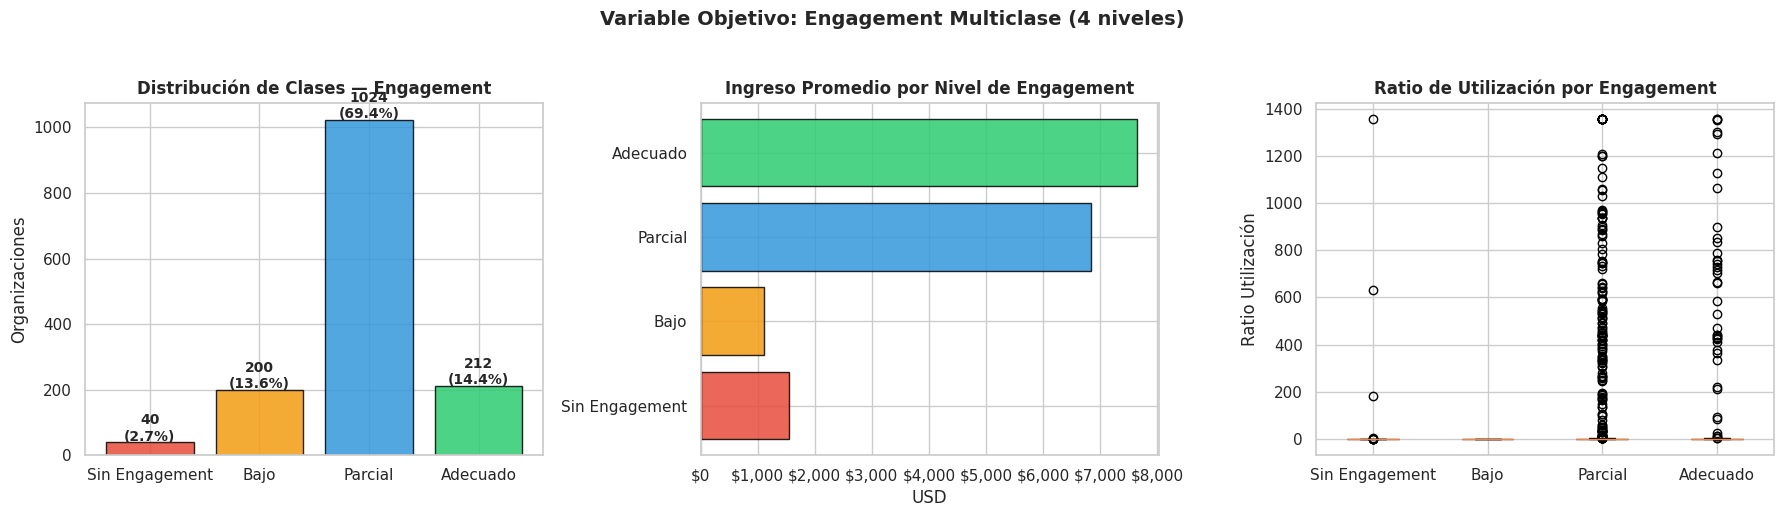

In [43]:
# Visualización de la variable objetivo
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Distribución de clases
ax = axes[0]
order = ['Sin Engagement', 'Bajo', 'Parcial', 'Adecuado']
colors = ['#e74c3c', '#f39c12', '#3498db', '#2ecc71']
counts = [df[df['engagement']==c].shape[0] for c in order]
bars = ax.bar(order, counts, color=colors, edgecolor='black', alpha=0.85)
for bar, c in zip(bars, counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
            f'{c}\n({c/len(df)*100:.1f}%)', ha='center', fontweight='bold', fontsize=10)
ax.set_title('Distribución de Clases — Engagement', fontweight='bold')
ax.set_ylabel('Organizaciones')

# 2. Ingresos promedio por engagement
ax = axes[1]
ing_eng = df.groupby('engagement')['total_ingresos'].mean().reindex(order)
ax.barh(order, ing_eng, color=colors, edgecolor='black', alpha=0.85)
ax.set_title('Ingreso Promedio por Nivel de Engagement', fontweight='bold')
ax.set_xlabel('USD')
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda v, _: f'${v:,.0f}'))

# 3. Ratio de utilización por engagement
ax = axes[2]
data_box = [df[df['engagement']==c]['ratio_utilizacion'].values for c in order]
bp = ax.boxplot(data_box, labels=order, patch_artist=True, vert=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax.set_title('Ratio de Utilización por Engagement', fontweight='bold')
ax.set_ylabel('Ratio Utilización')

plt.suptitle('Variable Objetivo: Engagement Multiclase (4 niveles)',
             fontsize=14, fontweight='bold', y=1.03)
plt.tight_layout()
plt.show()

In [44]:
# Codificación ordinal de la variable objetivo
engagement_map = {'Sin Engagement': 0, 'Bajo': 1, 'Parcial': 2, 'Adecuado': 3}
df['engagement_ord'] = df['engagement'].map(engagement_map)

print('Mapeo ordinal de engagement:')
for k, v in engagement_map.items():
    print(f'  {k:<18} → {v}')
print(f'\nValores únicos en engagement_ord: {sorted(df["engagement_ord"].unique())}')

Mapeo ordinal de engagement:
  Sin Engagement     → 0
  Bajo               → 1
  Parcial            → 2
  Adecuado           → 3

Valores únicos en engagement_ord: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]


<a name="binning"></a>
## 5. Discretización y Binning

> **Justificación:** El EDA mostró la necesidad de segmentar ingresos y variables de uso continuas. La discretización permite capturar relaciones no lineales, crear features categóricas para métodos como Chi-cuadrado, y generar segmentos interpretables para el negocio.

Se aplican dos estrategias:
1. **Binning por cuantiles** (equal-frequency): Garantiza distribución balanceada entre bins
2. **Binning por dominio de negocio**: Umbrales definidos por el contexto de la empresa (Avance 0)

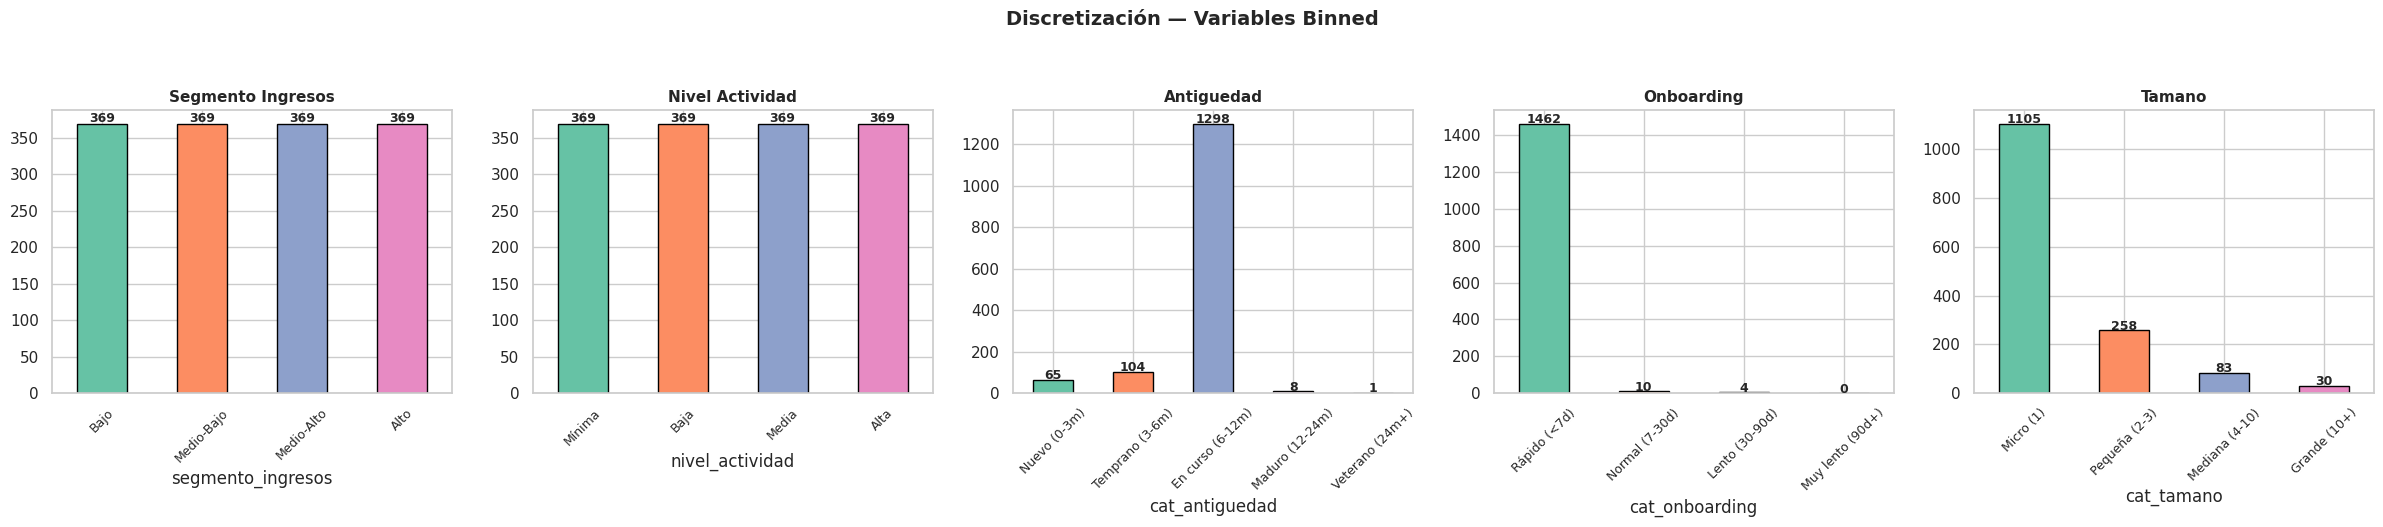


Variables discretizadas creadas:
  segmento_ingresos         4 categorías: ['Bajo', 'Medio-Bajo', 'Medio-Alto', 'Alto']
  nivel_actividad           4 categorías: ['Mínima', 'Baja', 'Media', 'Alta']
  cat_antiguedad            5 categorías: ['Nuevo (0-3m)', 'Temprano (3-6m)', 'En curso (6-12m)', 'Maduro (12-24m)', 'Veterano (24m+)']
  cat_onboarding            3 categorías: ['Rápido (<7d)', 'Normal (7-30d)', 'Lento (30-90d)', 'Muy lento (90d+)']
  cat_tamano                4 categorías: ['Micro (1)', 'Pequeña (2-3)', 'Mediana (4-10)', 'Grande (10+)']


In [45]:
# 5.1 Binning por cuantiles

# Segmento de ingresos (inspirado en EDA)
df['segmento_ingresos'] = pd.qcut(
    df['total_ingresos'], q=4,
    labels=['Bajo', 'Medio-Bajo', 'Medio-Alto', 'Alto'])

# Nivel de actividad (estudios)
df['nivel_actividad'] = pd.qcut(
    df['total_estudios'].clip(lower=0.1), q=4,
    labels=['Mínima', 'Baja', 'Media', 'Alta'],
    duplicates='drop')

# 5.2 Binning por dominio de negocio
# Antigüedad del cliente (categorías de madurez)
bins_ant = [0, 3, 6, 12, 24, np.inf]
labels_ant = ['Nuevo (0-3m)', 'Temprano (3-6m)', 'En curso (6-12m)',
              'Maduro (12-24m)', 'Veterano (24m+)']
df['cat_antiguedad'] = pd.cut(df['antiguedad_meses'], bins=bins_ant, labels=labels_ant,
                               include_lowest=True)

# Velocidad de onboarding (según propuesta: meta = 4 meses)
bins_onb = [0, 7, 30, 90, np.inf]
labels_onb = ['Rápido (<7d)', 'Normal (7-30d)', 'Lento (30-90d)', 'Muy lento (90d+)']
df['cat_onboarding'] = pd.cut(df['dias_onboarding'], bins=bins_onb, labels=labels_onb,
                               include_lowest=True)

# Tamaño de organización (por sucursales)
bins_tam = [0, 1, 3, 10, np.inf]
labels_tam = ['Micro (1)', 'Pequeña (2-3)', 'Mediana (4-10)', 'Grande (10+)']
df['cat_tamano'] = pd.cut(df['num_sucursales'], bins=bins_tam, labels=labels_tam,
                           include_lowest=True)

# Visualización
cats = ['segmento_ingresos', 'nivel_actividad', 'cat_antiguedad', 'cat_onboarding', 'cat_tamano']
fig, axes = plt.subplots(1, 5, figsize=(24, 5))

for ax, col in zip(axes, cats):
    vc = df[col].value_counts().sort_index()
    vc.plot.bar(ax=ax, color=sns.color_palette('Set2', len(vc)), edgecolor='black')
    ax.set_title(col.replace('cat_', '').replace('_', ' ').title(), fontweight='bold', fontsize=11)
    ax.tick_params(axis='x', rotation=45, labelsize=9)
    for i, v in enumerate(vc):
        ax.text(i, v + 2, str(v), ha='center', fontsize=9, fontweight='bold')

plt.suptitle('Discretización — Variables Binned', fontsize=14, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

print('\nVariables discretizadas creadas:')
for c in cats:
    print(f'  {c:<25} {df[c].nunique()} categorías: {df[c].cat.categories.tolist()}')

<a name="encoding"></a>
## 6. Codificación de Variables Categóricas

> **Motivación (EDA §7):** Se identificaron variables categóricas con distinta cardinalidad:
> - `product_type`: 5 valores → **One-Hot Encoding** (baja cardinalidad, sin orden)
> - `pais`: ~12 valores → **One-Hot Encoding** (baja cardinalidad, sin orden)
> - Variables binned (§5): con orden natural → **Ordinal Encoding**
> - `organization`: 721 valores → **No se codifica** (identificador, se excluye del modelo)

### 6.1 Justificación de cada técnica

| Variable | Cardinalidad | Orden natural | Técnica | Razón |
|----------|-------------|---------------|---------|-------|
| `product_type` | 5 | No | One-Hot | Evitar jerarquía artificial entre productos |
| `pais` | ~12 | No | One-Hot (agrupado) | Evitar jerarquía; agrupar países con pocos datos |
| `cat_antiguedad` | 5 | Sí | Ordinal | El orden temporal es significativo |
| `cat_onboarding` | 4 | Sí | Ordinal | Más rápido es estrictamente mejor |
| `cat_tamano` | 4 | Sí | Ordinal | Mayor tamaño = más complejidad |
| `segmento_ingresos` | 4 | Sí | Ordinal | Escala natural de ingresos |
| `nivel_actividad` | 4 | Sí | Ordinal | Más actividad = mayor uso |

In [46]:
# ══════════════════════════════════════════════════════════
# 6.2 One-Hot Encoding — Variables nominales
# ══════════════════════════════════════════════════════════

# Tipo de producto (del dataset de ingresos — asignar el producto principal por org)
prod_principal = (df_ingresos.groupby('name')
    .agg(prod=(COL_ING, 'idxmax')).reset_index())
prod_map = df_ingresos.loc[prod_principal['prod'], ['name', 'product_type']].set_index('name')['product_type']
df['product_type'] = df['organization'].map(prod_map).fillna('Desconocido')

# Agrupar países con pocos datos
top_paises = df['pais'].value_counts()
df['pais_agrupado'] = df['pais'].where(df['pais'].isin(top_paises[top_paises >= 10].index), 'Otro')

# One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=['product_type', 'pais_agrupado'],
                             prefix=['prod', 'pais'], drop_first=False)

# Mostrar columnas generadas
ohe_cols = [c for c in df_encoded.columns if c.startswith('prod_') or c.startswith('pais_')]
print('One-Hot Encoding — columnas generadas:')
for c in ohe_cols:
    n1 = df_encoded[c].sum()
    print(f'  {c:<35} {n1:>4} ({n1/len(df_encoded)*100:.1f}%)')

# ══════════════════════════════════════════════════════════
# 6.3 Ordinal Encoding — Variables con orden natural
# ══════════════════════════════════════════════════════════

ordinal_maps = {
    'cat_antiguedad': {'Nuevo (0-3m)': 0, 'Temprano (3-6m)': 1, 'En curso (6-12m)': 2,
                       'Maduro (12-24m)': 3, 'Veterano (24m+)': 4},
    'cat_onboarding': {'Rápido (<7d)': 0, 'Normal (7-30d)': 1, 'Lento (30-90d)': 2,
                       'Muy lento (90d+)': 3},
    'cat_tamano': {'Micro (1)': 0, 'Pequeña (2-3)': 1, 'Mediana (4-10)': 2, 'Grande (10+)': 3},
    'segmento_ingresos': {'Bajo': 0, 'Medio-Bajo': 1, 'Medio-Alto': 2, 'Alto': 3},
    'nivel_actividad': {'Mínima': 0, 'Baja': 1, 'Media': 2, 'Alta': 3},
}

print('\nOrdinal Encoding:')
for col, mapping in ordinal_maps.items():
    df_encoded[f'{col}_ord'] = df_encoded[col].map(mapping).fillna(0).astype(int)
    print(f'  {col} → {col}_ord  {mapping}')

print(f'\n Codificación completada: {df_encoded.shape[1]} columnas totales')

One-Hot Encoding — columnas generadas:
  prod_PACS_FIXED_FEE                  369 (25.0%)
  prod_PACS_HIGH_LOW_STUDIES          1046 (70.9%)
  prod_PACS_HIGH_PRICE                   9 (0.6%)
  prod_PACS_NO_DICOM_STUDY              42 (2.8%)
  prod_PACS_STUDY_LOW_PRICE             10 (0.7%)
  pais_Brasil                           30 (2.0%)
  pais_Chile                            13 (0.9%)
  pais_Colombia                         10 (0.7%)
  pais_Costa Rica                       39 (2.6%)
  pais_Desconocido                     114 (7.7%)
  pais_Ecuador                          20 (1.4%)
  pais_Guatemala                        29 (2.0%)
  pais_Honduras                         19 (1.3%)
  pais_Mexico                         1134 (76.8%)
  pais_Otro                             22 (1.5%)
  pais_Panama                           18 (1.2%)
  pais_Peru                             28 (1.9%)

Ordinal Encoding:
  cat_antiguedad → cat_antiguedad_ord  {'Nuevo (0-3m)': 0, 'Temprano (3-6m)': 1, 'En curs

<a name="transformaciones"></a>
## 7. Transformaciones Matemáticas

> **Motivación (EDA §8):** Todas las variables numéricas presentan sesgo extremo positivo (skewness > 8). La Fase 1 aplicó `log(x+1)` de forma exploratoria. Ahora se comparan formalmente tres transformaciones para seleccionar la óptima por variable:
>
> 1. **Log(x+1):** Referencia del EDA; efectiva para distribuciones log-normales
> 2. **Yeo-Johnson:** Generalización que maneja valores negativos y ceros
> 3. **Box-Cox:** Potencia óptima, requiere datos estrictamente positivos
>
> **Criterio de selección:** Se elige la transformación que minimice |skewness| para cada variable.

In [47]:
# ── Variables a transformar ───────────────────────────
cols_transform = ['total_ingresos', 'total_estudios', 'total_usuarios', 'envios_email',
                  'envios_sms', 'firmados', 'total_pacs', 'potencial_mensual',
                  'promedio_ingresos', 'estudios_mod', 'total_envios',
                  'estudios_por_sucursal', 'usuarios_por_sucursal']

results = []
yj = PowerTransformer(method='yeo-johnson')
bc = PowerTransformer(method='box-cox')

for col in cols_transform:
    serie = df_encoded[col].dropna()

    # Original
    sk_orig = skew(serie)

    # Log(x+1)
    log_vals = np.log1p(serie)
    sk_log = skew(log_vals)

    # Yeo-Johnson
    try:
        yj_vals = yj.fit_transform(serie.values.reshape(-1, 1)).ravel()
        sk_yj = skew(yj_vals)
    except:
        sk_yj = np.inf

    # Box-Cox (requiere > 0)
    serie_pos = serie[serie > 0]
    try:
        if len(serie_pos) > 10:
            bc_vals = bc.fit_transform(serie_pos.values.reshape(-1, 1)).ravel()
            sk_bc = skew(bc_vals)
        else:
            sk_bc = np.inf
    except:
        sk_bc = np.inf

    # Mejor transformación
    options = {'Original': abs(sk_orig), 'Log(x+1)': abs(sk_log),
               'Yeo-Johnson': abs(sk_yj), 'Box-Cox': abs(sk_bc)}
    best = min(options, key=options.get)

    results.append({
        'Variable': col, 'Skew_Original': round(sk_orig, 2),
        'Skew_Log': round(sk_log, 2), 'Skew_YeoJohnson': round(sk_yj, 2),
        'Skew_BoxCox': round(sk_bc, 2) if sk_bc != np.inf else '—',
        'Mejor': best, '|Skew| Final': round(min(options.values()), 3)
    })

df_trans = pd.DataFrame(results)

def highlight_best(row):
    styles = [''] * len(row)
    best = row['Mejor']
    col_map = {'Log(x+1)': 'Skew_Log', 'Yeo-Johnson': 'Skew_YeoJohnson',
               'Box-Cox': 'Skew_BoxCox', 'Original': 'Skew_Original'}
    if best in col_map and col_map[best] in row.index:
        idx = row.index.get_loc(col_map[best])
        styles[idx] = 'background-color: #2ecc71; color: white; font-weight: bold'
    return styles

display(df_trans.style.apply(highlight_best, axis=1))

,Variable,Skew_Original,Skew_Log,Skew_YeoJohnson,Skew_BoxCox,Mejor,|Skew| Final
0,total_ingresos,3.780000,-0.830000,-0.020000,-0.020000,Box-Cox,0.016000
1,total_estudios,5.470000,-0.710000,-0.020000,-0.010000,Box-Cox,0.014000
2,total_usuarios,3.410000,-0.510000,-0.050000,-0.020000,Box-Cox,0.019000
3,envios_email,4.180000,0.100000,0.020000,-0.000000,Box-Cox,0.004000
4,envios_sms,3.790000,-0.770000,-0.060000,-0.040000,Box-Cox,0.036000
5,firmados,6.220000,-0.120000,-0.020000,-0.020000,Box-Cox,0.017000
6,total_pacs,5.510000,-0.690000,-0.020000,-0.010000,Box-Cox,0.012000
7,potencial_mensual,1.480000,-0.870000,-0.160000,-0.140000,Box-Cox,0.144000
8,promedio_ingresos,18.100000,-0.230000,-0.000000,0.000000,Yeo-Johnson,0.002000
9,estudios_mod,5.530000,-0.710000,-0.020000,-0.010000,Box-Cox,0.012000


Transformaciones aplicadas:
  total_ingresos                 → t_total_ingresos  (Box-Cox)
  total_estudios                 → t_total_estudios  (Box-Cox)
  total_usuarios                 → t_total_usuarios  (Box-Cox)
  envios_email                   → t_envios_email  (Box-Cox)
  envios_sms                     → t_envios_sms  (Box-Cox)
  firmados                       → t_firmados  (Box-Cox)
  total_pacs                     → t_total_pacs  (Box-Cox)
  potencial_mensual              → t_potencial_mensual  (Box-Cox)
  promedio_ingresos              → t_promedio_ingresos  (Yeo-Johnson)
  estudios_mod                   → t_estudios_mod  (Box-Cox)
  total_envios                   → t_total_envios  (Box-Cox)
  estudios_por_sucursal          → t_estudios_por_sucursal  (Box-Cox)
  usuarios_por_sucursal          → t_usuarios_por_sucursal  (Box-Cox)


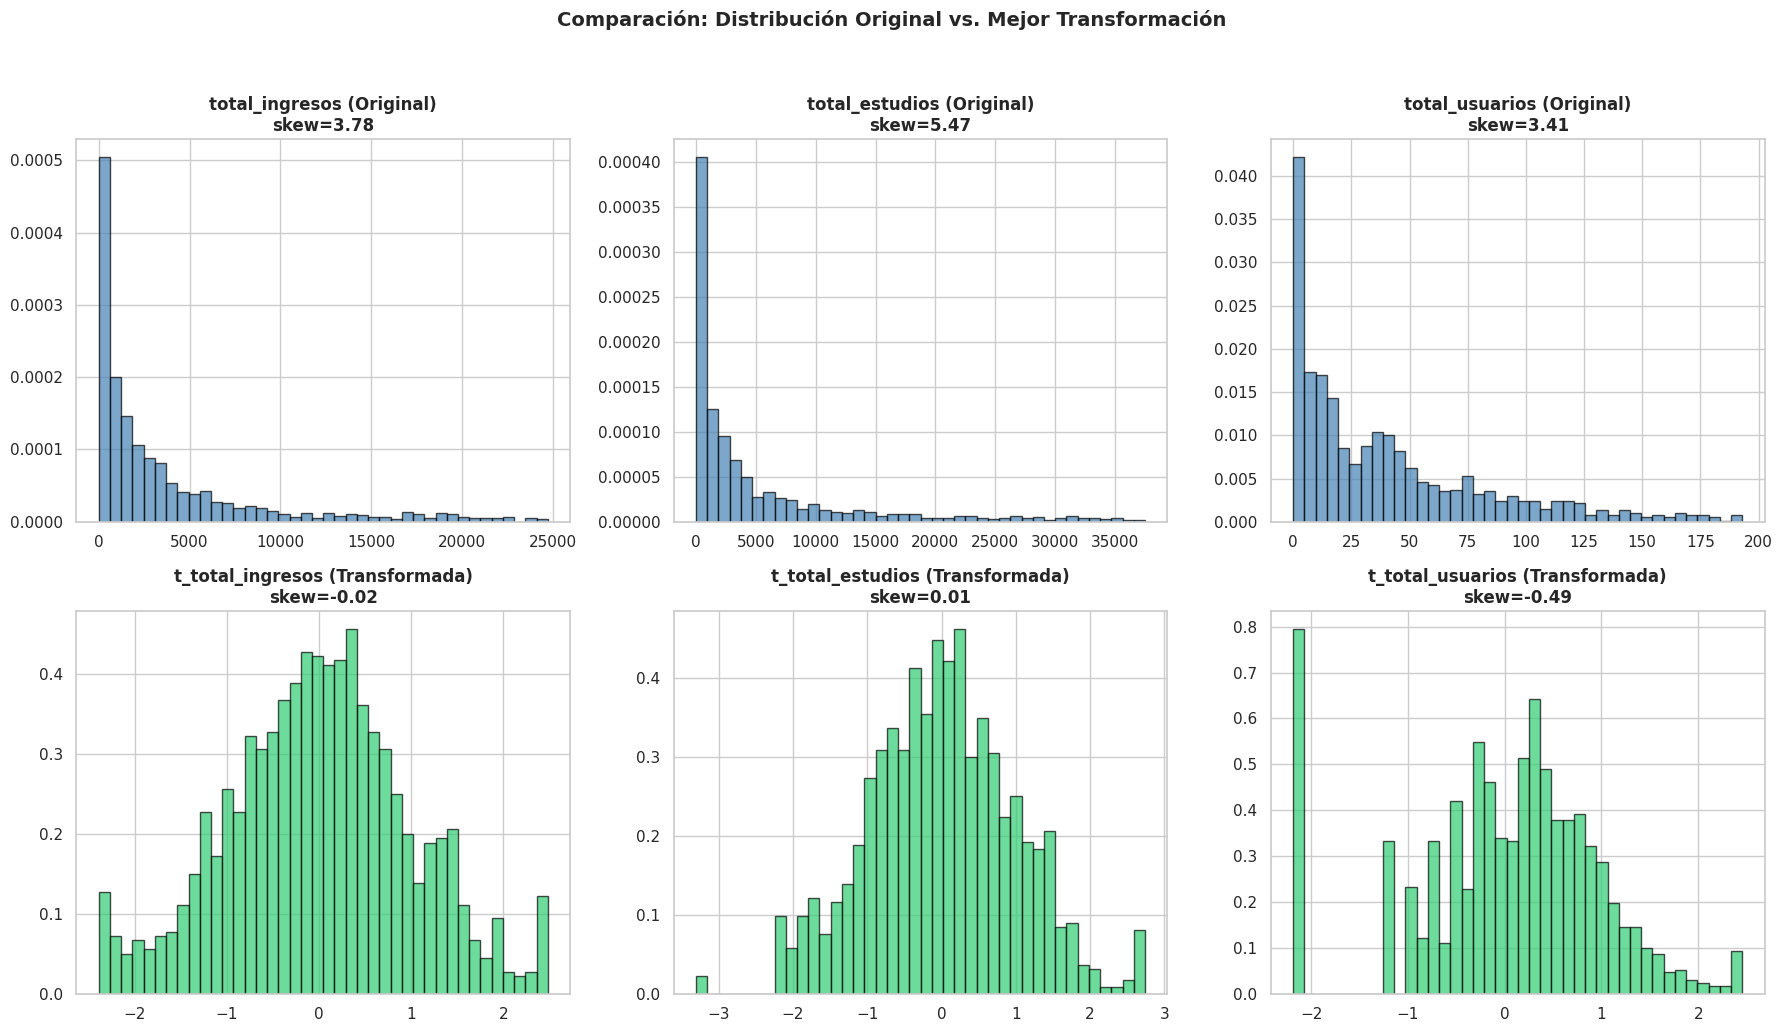

In [48]:
# ── Aplicar la mejor transformación por variable ─────
print('Transformaciones aplicadas:')
for _, row in df_trans.iterrows():
    col = row['Variable']
    best = row['Mejor']
    serie = df_encoded[col].fillna(0)

    if best == 'Log(x+1)':
        df_encoded[f't_{col}'] = np.log1p(serie)
    elif best == 'Yeo-Johnson':
        pt = PowerTransformer(method='yeo-johnson')
        df_encoded[f't_{col}'] = pt.fit_transform(serie.values.reshape(-1, 1)).ravel()
    elif best == 'Box-Cox':
        serie_pos = serie.clip(lower=1e-6)  # Evitar ceros estrictos
        pt = PowerTransformer(method='box-cox')
        df_encoded[f't_{col}'] = pt.fit_transform(serie_pos.values.reshape(-1, 1)).ravel()
    else:
        df_encoded[f't_{col}'] = serie  # Mantener original

    print(f'  {col:<30} → t_{col}  ({best})')

# ── Visualización comparativa ────────────────────────
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
sample_vars = ['total_ingresos', 'total_estudios', 'total_usuarios']

for i, col in enumerate(sample_vars):
    # Original
    ax = axes[0, i]
    serie = df_encoded[col].dropna()
    ax.hist(serie[serie <= serie.quantile(.95)], bins=40, color='steelblue',
            edgecolor='black', alpha=0.7, density=True)
    ax.set_title(f'{col} (Original)\nskew={skew(serie):.2f}', fontweight='bold')

    # Transformada
    ax = axes[1, i]
    t_col = f't_{col}'
    t_serie = df_encoded[t_col].dropna()
    ax.hist(t_serie, bins=40, color='#2ecc71', edgecolor='black', alpha=0.7, density=True)
    ax.set_title(f'{t_col} (Transformada)\nskew={skew(t_serie):.2f}', fontweight='bold')

plt.suptitle('Comparación: Distribución Original vs. Mejor Transformación',
             fontsize=14, fontweight='bold', y=1.03)
plt.tight_layout()
plt.show()

<a name="escalamiento"></a>
## 8. Escalamiento de Variables

> **Justificación:** Diferentes algoritmos de ML requieren diferentes escalas:
> - **StandardScaler (Z-score):** Para modelos que asumen normalidad (regresión logística, SVM)
> - **MinMaxScaler [0, 1]:** Para redes neuronales y distancias euclidianas (KNN)
> - **RobustScaler:** Resistente a outliers residuales (usa mediana e IQR)
>
> Se preparan las tres versiones para evaluar en la Fase 3 cuál funciona mejor con cada algoritmo.

### 8.1 Selección de features numéricos para escalar

In [49]:
# ── Features numéricos para escalar ───────────────────
# Usar variables transformadas + ratios + temporales
features_num = [c for c in df_encoded.columns if c.startswith('t_')] + \
               ratios + temporal + \
               ['meses_facturado', 'num_sucursales', 'num_modalidades',
                'prom_usuarios', 'estudios_ai_torax', 'estudios_ai_report']

# Eliminar duplicados y verificar existencia
features_num = [c for c in dict.fromkeys(features_num) if c in df_encoded.columns]

print(f'Features numéricos a escalar: {len(features_num)}')
X_num = df_encoded[features_num].fillna(0)

# ── Aplicar los 3 escaladores ────────────────────────
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

scaled_dfs = {}
for name, scaler in scalers.items():
    scaled_vals = scaler.fit_transform(X_num)
    scaled_dfs[name] = pd.DataFrame(scaled_vals, columns=features_num, index=X_num.index)
    print(f'\n{name}:')
    print(f'  Rango: [{scaled_vals.min():.3f}, {scaled_vals.max():.3f}]')
    print(f'  Media:  {scaled_vals.mean():.4f}')
    print(f'  Std:    {scaled_vals.std():.4f}')

Features numéricos a escalar: 33

StandardScaler:
  Rango: [-3.718, 37.142]
  Media:  0.0000
  Std:    1.0000

MinMaxScaler:
  Rango: [0.000, 1.000]
  Media:  0.2828
  Std:    0.2887

RobustScaler:
  Rango: [-6.400, 60157.000]
  Media:  3.8515
  Std:    284.6807


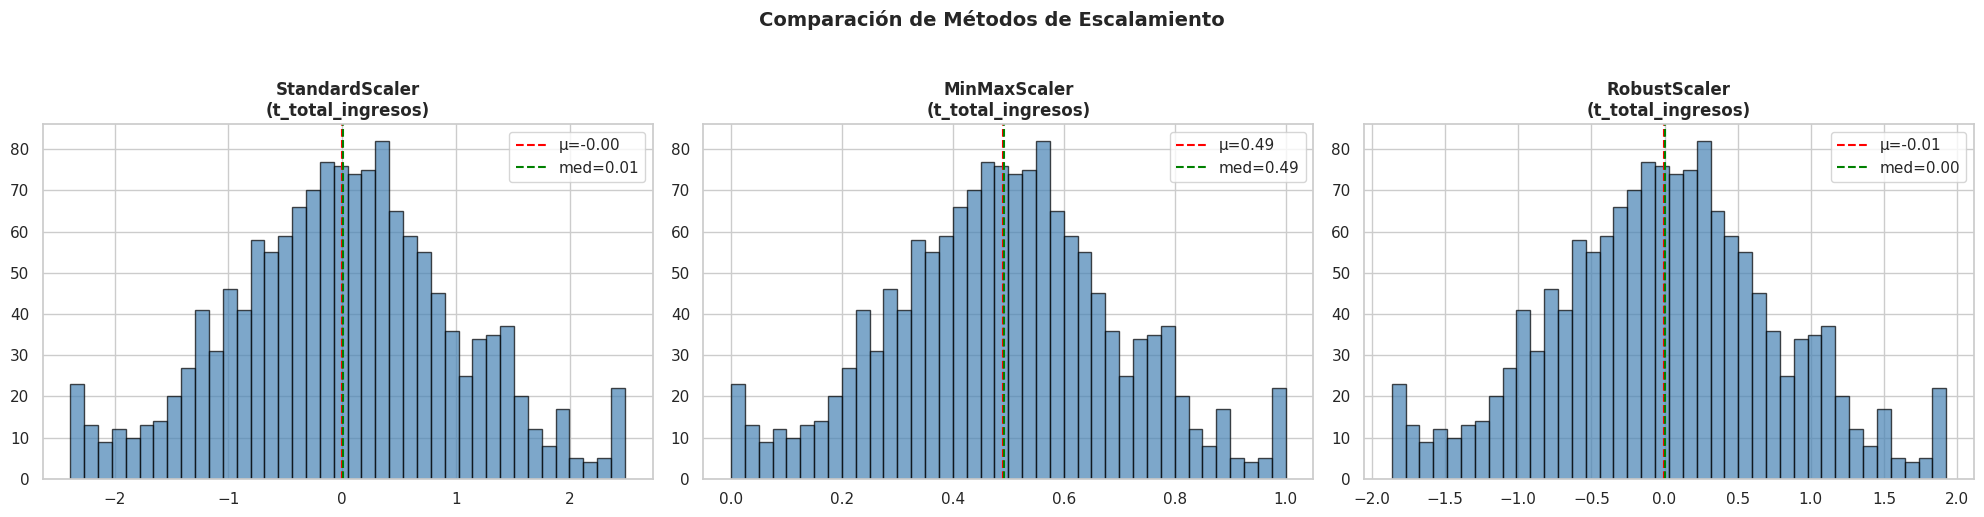


📋 Resumen de escaladores — Se guardan las 3 versiones para Fase 3:
  • StandardScaler → Recomendado para: Regresión Logística, SVM, PCA
  • MinMaxScaler   → Recomendado para: Redes Neuronales, KNN
  • RobustScaler   → Recomendado para: Algoritmos sensibles a outliers residuales
  • Sin escalar    → Recomendado para: Random Forest, XGBoost (invariantes a escala)


In [50]:
# ── Visualización comparativa ────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
sample_feat = features_num[0]  # Primera feature transformada

for ax, (name, sdf) in zip(axes, scaled_dfs.items()):
    ax.hist(sdf[sample_feat], bins=40, color='steelblue', edgecolor='black', alpha=0.7)
    ax.set_title(f'{name}\n({sample_feat})', fontweight='bold')
    ax.axvline(sdf[sample_feat].mean(), color='red', ls='--', lw=1.5, label=f'μ={sdf[sample_feat].mean():.2f}')
    ax.axvline(sdf[sample_feat].median(), color='green', ls='--', lw=1.5, label=f'med={sdf[sample_feat].median():.2f}')
    ax.legend()

plt.suptitle('Comparación de Métodos de Escalamiento', fontsize=14, fontweight='bold', y=1.03)
plt.tight_layout()
plt.show()

# ── Tabla resumen ────────────────────────────────────
print('\n📋 Resumen de escaladores — Se guardan las 3 versiones para Fase 3:')
print('  • StandardScaler → Recomendado para: Regresión Logística, SVM, PCA')
print('  • MinMaxScaler   → Recomendado para: Redes Neuronales, KNN')
print('  • RobustScaler   → Recomendado para: Algoritmos sensibles a outliers residuales')
print('  • Sin escalar    → Recomendado para: Random Forest, XGBoost (invariantes a escala)')

<a name="seleccion"></a>
## 9. Selección de Características — Métodos de Filtrado

> **Objetivo:** Reducir la dimensionalidad eliminando features redundantes o poco informativos, para disminuir complejidad, tiempo de entrenamiento y riesgo de sobreajuste (CRISP-ML).
>
> **Conexión con EDA:** La matriz de correlación mostró correlaciones > 0.90 entre variables de uso (`total_pacs` ↔ `total_estudios` ↔ `firmados`), señalando redundancia.

Se aplican cinco métodos de filtrado complementarios:

### 9.1 Umbral de Varianza

**Justificación:** Features con varianza cercana a cero no aportan información discriminativa. Se eliminan features con varianza < 0.01 (después de escalar a [0,1]).

Umbral de varianza (< 0.01):
  Features originales: 33
  Eliminadas:          9
  Conservadas:         24

  Features eliminadas por baja varianza:
    ✗ estudios_ai_torax  (var=0.000723)
    ✗ prom_usuarios  (var=0.000863)
    ✗ num_sucursales  (var=0.000899)
    ✗ estudios_ai_report  (var=0.001437)
    ✗ ratio_envio_sms  (var=0.001940)
    ✗ dias_onboarding  (var=0.002247)
    ✗ num_modalidades  (var=0.003049)
    ✗ ratio_envio_total  (var=0.003798)
    ✗ antiguedad_meses  (var=0.004316)


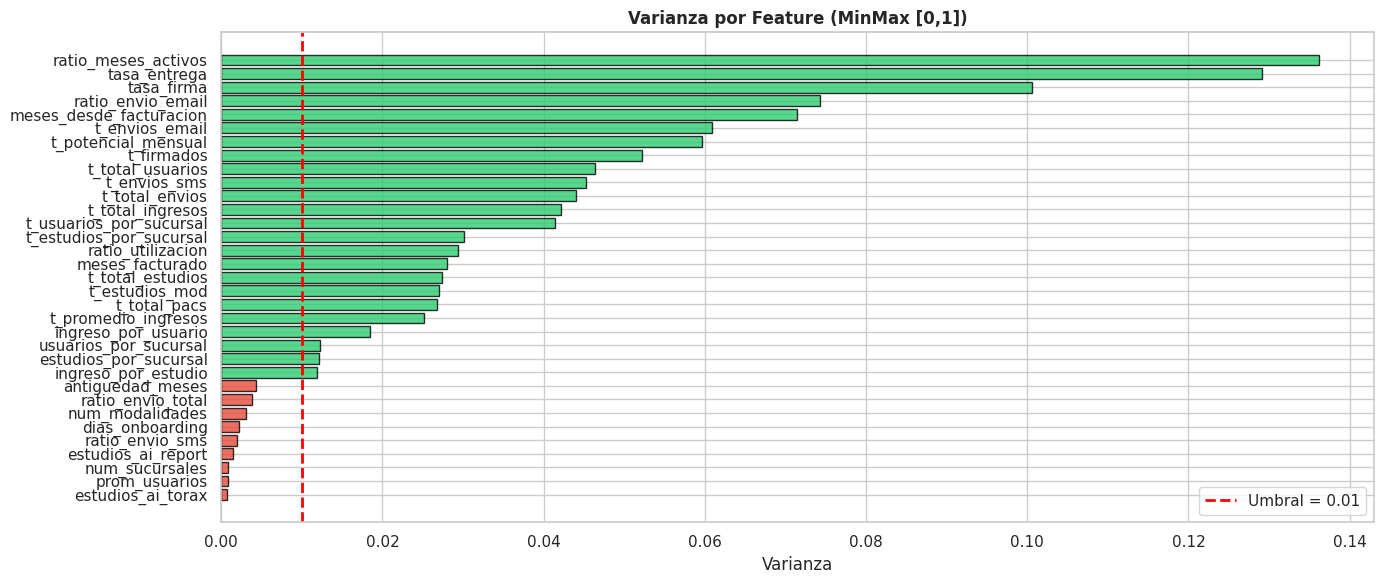

In [51]:
# ── 9.1 Umbral de Varianza ────────────────────────────
# Escalar a [0,1] para comparar varianzas
X_minmax = scaled_dfs['MinMaxScaler']

selector_var = VarianceThreshold(threshold=0.01)
selector_var.fit(X_minmax)

var_scores = pd.DataFrame({
    'Feature': features_num,
    'Varianza': selector_var.variances_
}).sort_values('Varianza')

# Features eliminadas
eliminated_var = var_scores[var_scores['Varianza'] < 0.01]['Feature'].tolist()
kept_var = var_scores[var_scores['Varianza'] >= 0.01]['Feature'].tolist()

print(f'Umbral de varianza (< 0.01):')
print(f'  Features originales: {len(features_num)}')
print(f'  Eliminadas:          {len(eliminated_var)}')
print(f'  Conservadas:         {len(kept_var)}')

if eliminated_var:
    print(f'\n  Features eliminadas por baja varianza:')
    for f in eliminated_var:
        print(f'    ✗ {f}  (var={var_scores[var_scores["Feature"]==f]["Varianza"].values[0]:.6f})')

# Visualización
fig, ax = plt.subplots(figsize=(14, 6))
colors = ['#e74c3c' if v < 0.01 else '#2ecc71' for v in var_scores['Varianza']]
ax.barh(var_scores['Feature'], var_scores['Varianza'], color=colors, edgecolor='black', alpha=0.8)
ax.axvline(0.01, color='red', ls='--', lw=2, label='Umbral = 0.01')
ax.set_title('Varianza por Feature (MinMax [0,1])', fontweight='bold')
ax.set_xlabel('Varianza')
ax.legend()
plt.tight_layout()
plt.show()

### 9.2 Filtro por Correlación

**Justificación (EDA):** Se detectó multicolinealidad severa entre variables de uso (r > 0.90). Se eliminan features cuya correlación con otro feature supere |0.90|, conservando el más correlacionado con la variable objetivo.

Pares con |r| > 0.90: 9
  t_estudios_mod ↔ t_total_estudios  (r=0.999)
  t_total_pacs ↔ t_estudios_mod  (r=0.999)
  t_total_pacs ↔ t_total_estudios  (r=0.998)
  t_total_envios ↔ t_envios_sms  (r=0.989)
  t_total_estudios ↔ t_estudios_por_sucursal  (r=0.937)
  t_estudios_mod ↔ t_estudios_por_sucursal  (r=0.935)
  t_total_pacs ↔ t_estudios_por_sucursal  (r=0.934)
  t_promedio_ingresos ↔ t_total_ingresos  (r=0.926)
  t_usuarios_por_sucursal ↔ t_total_usuarios  (r=0.907)
    → Eliminar: t_total_pacs (corr_target=0.474) | Conservar: t_estudios_mod (corr_target=0.476)
    → Eliminar: t_total_pacs (corr_target=0.474) | Conservar: t_total_estudios (corr_target=0.477)
    → Eliminar: t_estudios_mod (corr_target=0.476) | Conservar: t_total_estudios (corr_target=0.477)
    → Eliminar: t_estudios_por_sucursal (corr_target=0.471) | Conservar: t_total_pacs (corr_target=0.474)
    → Eliminar: t_estudios_por_sucursal (corr_target=0.471) | Conservar: t_estudios_mod (corr_target=0.476)
    → Eliminar: t

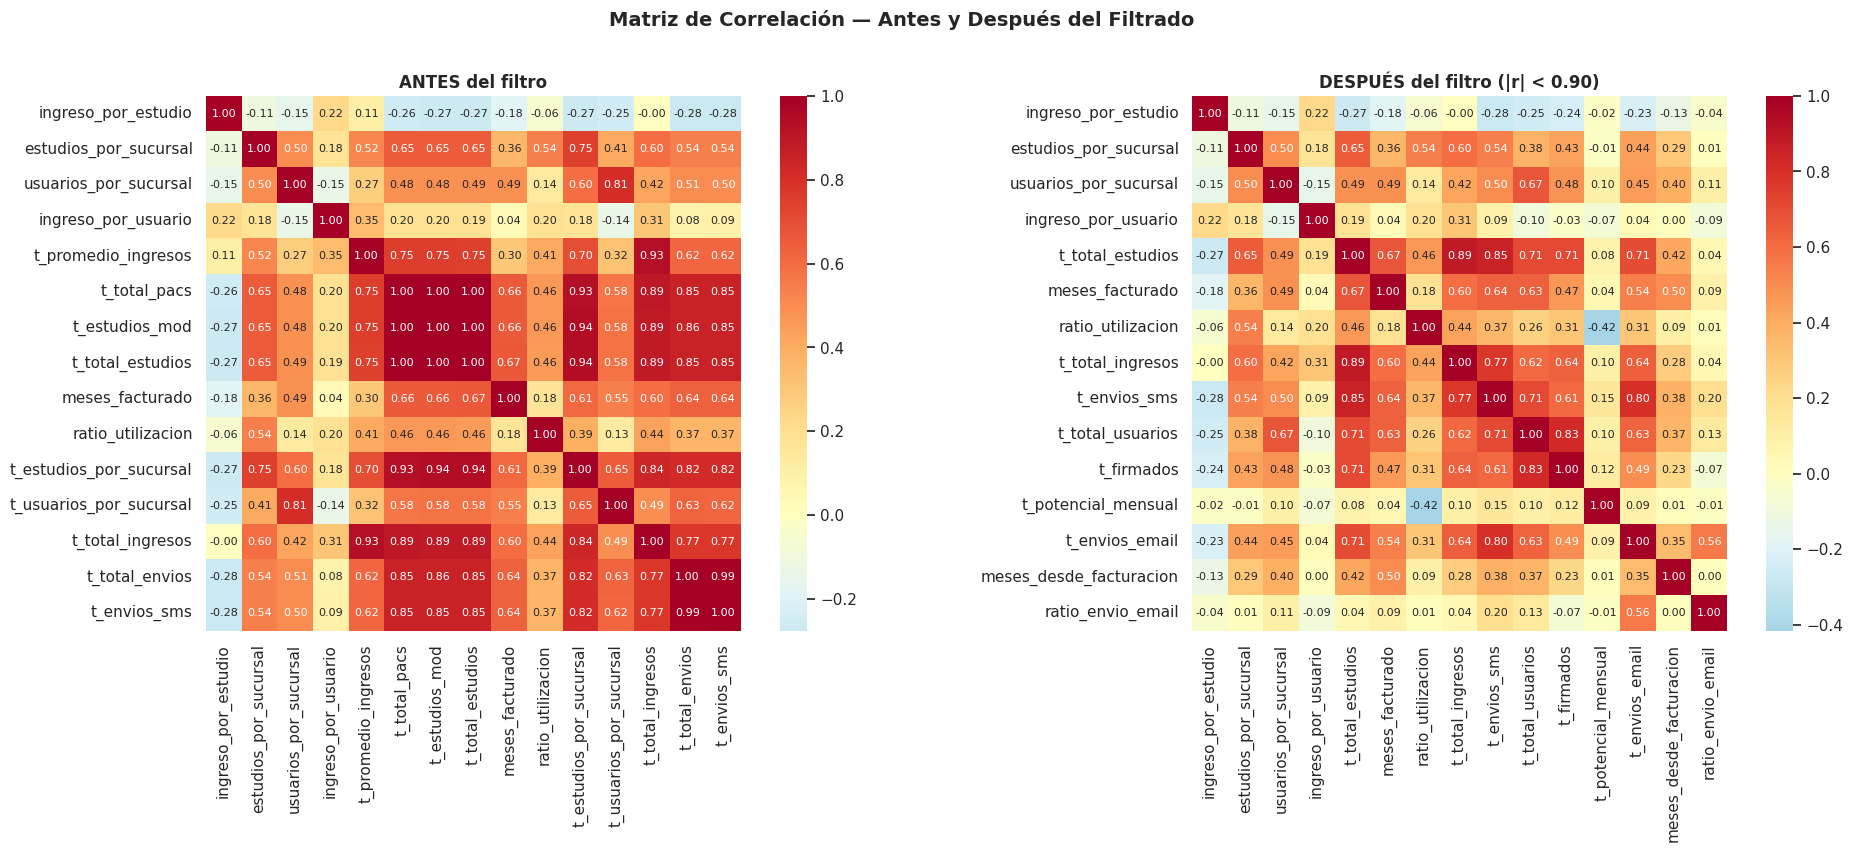

In [52]:
# ── 9.2 Filtro por Correlación (|r| > 0.90) ──────────
X_for_corr = df_encoded[kept_var].fillna(0)
corr_matrix = X_for_corr.corr().abs()

# Identificar pares altamente correlacionados
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_pairs = []
for col in upper_tri.columns:
    for idx in upper_tri.index:
        if upper_tri.loc[idx, col] > 0.90:
            high_corr_pairs.append((idx, col, upper_tri.loc[idx, col]))

print(f'Pares con |r| > 0.90: {len(high_corr_pairs)}')
for f1, f2, r in sorted(high_corr_pairs, key=lambda x: -x[2]):
    print(f'  {f1} ↔ {f2}  (r={r:.3f})')

# Decidir cuál eliminar: conservar el más correlacionado con engagement
target = df_encoded['engagement_ord']
to_drop_corr = set()
for f1, f2, r in high_corr_pairs:
    corr1 = abs(df_encoded[f1].fillna(0).corr(target))
    corr2 = abs(df_encoded[f2].fillna(0).corr(target))
    drop = f2 if corr1 >= corr2 else f1
    keep = f1 if drop == f2 else f2
    to_drop_corr.add(drop)
    print(f'    → Eliminar: {drop} (corr_target={min(corr1,corr2):.3f}) | Conservar: {keep} (corr_target={max(corr1,corr2):.3f})')

kept_corr = [f for f in kept_var if f not in to_drop_corr]
print(f'\nResultado: {len(kept_var)} → {len(kept_corr)} features (eliminadas: {len(to_drop_corr)})')

# Heatmap post-filtrado
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

ax = axes[0]
sns.heatmap(X_for_corr[kept_var[:15]].corr(), annot=True, fmt='.2f', cmap='RdYlBu_r',
            center=0, square=True, ax=ax, annot_kws={'size': 8})
ax.set_title('ANTES del filtro', fontweight='bold')

ax = axes[1]
if len(kept_corr) > 0:
    sns.heatmap(df_encoded[kept_corr[:15]].fillna(0).corr(), annot=True, fmt='.2f',
                cmap='RdYlBu_r', center=0, square=True, ax=ax, annot_kws={'size': 8})
ax.set_title('DESPUÉS del filtro (|r| < 0.90)', fontweight='bold')

plt.suptitle('Matriz de Correlación — Antes y Después del Filtrado',
             fontsize=14, fontweight='bold', y=1.03)
plt.tight_layout()
plt.show()

### 9.3 ANOVA F-test

**Justificación:** ANOVA evalúa si las medias de cada feature difieren significativamente entre las clases de engagement. Un F-statistic alto indica que la variable discrimina bien entre niveles de engagement.

**Supuesto:** Features numéricas continuas, variable objetivo categórica (engagement multiclase).

ANOVA F-test:
  Significativas (p < 0.05): 18
  No significativas:         0


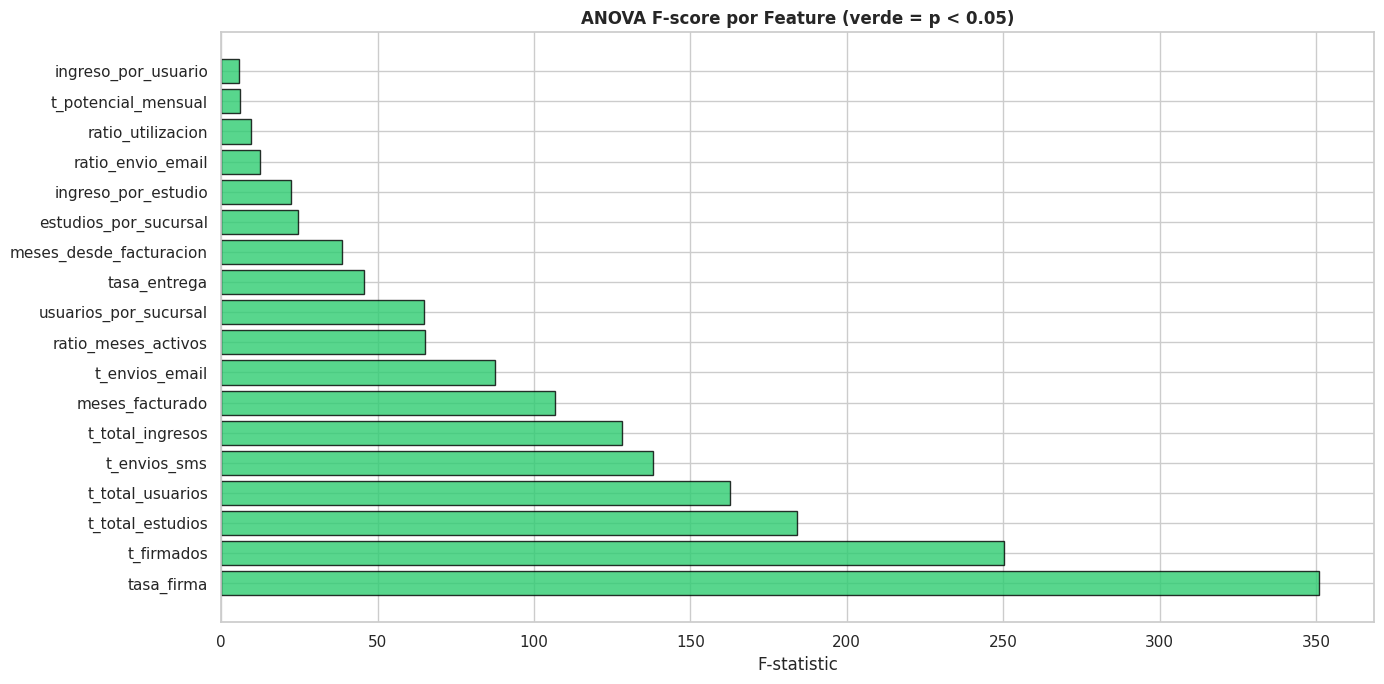

,Feature,F_score,p_value
15,tasa_firma,350.99,0.0000
10,t_firmados,250.23,0.0000
4,t_total_estudios,184.14,0.0000
9,t_total_usuarios,162.79,0.0000
8,t_envios_sms,137.99,0.0000
7,t_total_ingresos,128.05,0.0000
5,meses_facturado,106.80,0.0000
12,t_envios_email,87.65,0.0000
17,ratio_meses_activos,65.22,0.0000
2,usuarios_por_sucursal,64.80,0.0000


In [53]:
# ── 9.3 ANOVA F-test ─────────────────────────────────
X_anova = df_encoded[kept_corr].fillna(0)
y_anova = df_encoded['engagement_ord']

selector_anova = SelectKBest(f_classif, k='all')
selector_anova.fit(X_anova, y_anova)

anova_scores = pd.DataFrame({
    'Feature': kept_corr,
    'F_score': selector_anova.scores_,
    'p_value': selector_anova.pvalues_
}).sort_values('F_score', ascending=False)

# Features significativas (p < 0.05)
anova_sig = anova_scores[anova_scores['p_value'] < 0.05]
anova_nosig = anova_scores[anova_scores['p_value'] >= 0.05]

print(f'ANOVA F-test:')
print(f'  Significativas (p < 0.05): {len(anova_sig)}')
print(f'  No significativas:         {len(anova_nosig)}')

if len(anova_nosig) > 0:
    print(f'\n  Features NO significativas (candidatas a eliminación):')
    for _, row in anova_nosig.iterrows():
        print(f'    ✗ {row["Feature"]:<35} F={row["F_score"]:.2f}  p={row["p_value"]:.4f}')

# Visualización
fig, ax = plt.subplots(figsize=(14, 7))
colors = ['#2ecc71' if p < 0.05 else '#e74c3c' for p in anova_scores['p_value']]
bars = ax.barh(anova_scores['Feature'], anova_scores['F_score'], color=colors,
               edgecolor='black', alpha=0.8)
ax.set_title('ANOVA F-score por Feature (verde = p < 0.05)', fontweight='bold')
ax.set_xlabel('F-statistic')
plt.tight_layout()
plt.show()

display(anova_scores.head(15).style.format({'F_score': '{:.2f}', 'p_value': '{:.4f}'})
        .background_gradient(subset=['F_score'], cmap='Greens'))

### 9.4 Chi-cuadrado (χ²)

**Justificación:** Chi-cuadrado evalúa la independencia estadística entre variables categóricas/discretas y la variable objetivo. Se aplica sobre los features binarios (flags) y las variables discretizadas (ordinal-encoded).

**Requisito:** Datos no negativos (se usa MinMaxScaler).

Chi-cuadrado — Top 15 features categóricos:


,Feature,Chi2_score,p_value
28,nivel_actividad_ord,260.12,0.0000
27,segmento_ingresos_ord,191.34,0.0000
26,cat_tamano_ord,53.80,0.0000
5,es_multi_sucursal,36.46,0.0000
6,es_multi_modalidad,32.37,0.0000
3,usa_email,27.60,0.0000
10,prod_PACS_NO_DICOM_STUDY,23.77,0.0000
4,usa_sms,16.63,0.0008
25,cat_onboarding_ord,10.48,0.0149
24,cat_antiguedad_ord,9.81,0.0203


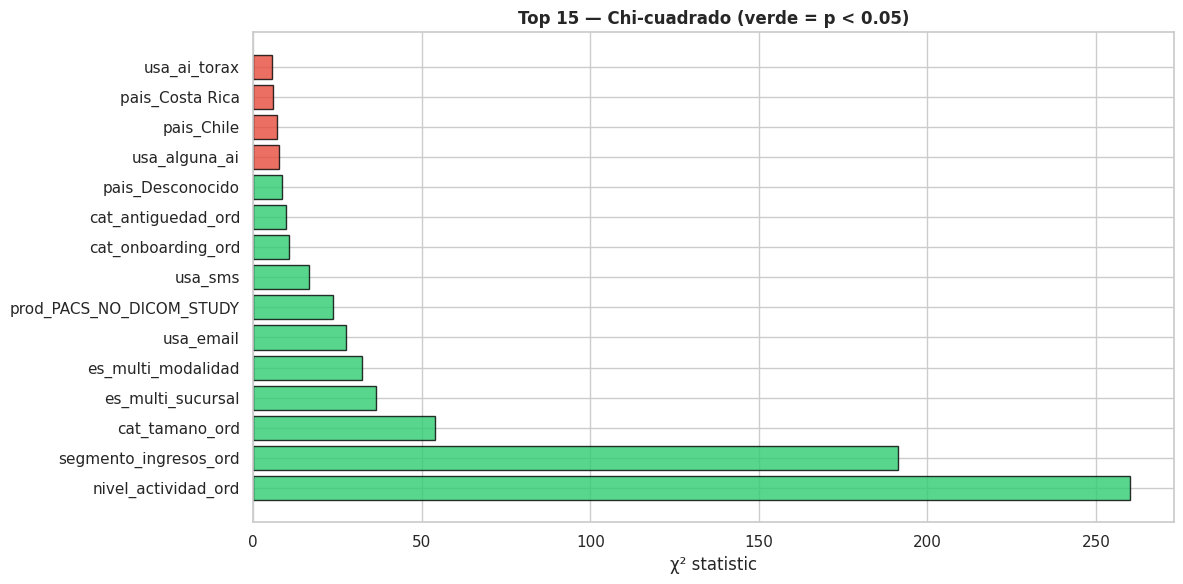

In [54]:
# ── 9.4 Chi-cuadrado ─────────────────────────────────
# Seleccionar features categóricas codificadas + flags
chi2_features = (flags +
                 [c for c in df_encoded.columns if c.startswith('prod_') or c.startswith('pais_')] +
                 [f'{c}_ord' for c in ordinal_maps.keys() if f'{c}_ord' in df_encoded.columns])

# Eliminar duplicados
chi2_features = list(dict.fromkeys(chi2_features))
chi2_features = [f for f in chi2_features if f in df_encoded.columns]

X_chi2 = df_encoded[chi2_features].fillna(0)
y_chi2 = df_encoded['engagement_ord']

# Asegurar no negativos
X_chi2 = X_chi2.clip(lower=0)

selector_chi2 = SelectKBest(chi2, k='all')
selector_chi2.fit(X_chi2, y_chi2)

chi2_scores = pd.DataFrame({
    'Feature': chi2_features,
    'Chi2_score': selector_chi2.scores_,
    'p_value': selector_chi2.pvalues_
}).sort_values('Chi2_score', ascending=False)

print('Chi-cuadrado — Top 15 features categóricos:')
display(chi2_scores.head(15).style.format({'Chi2_score': '{:.2f}', 'p_value': '{:.4f}'})
        .background_gradient(subset=['Chi2_score'], cmap='Oranges'))

# Visualización
fig, ax = plt.subplots(figsize=(12, 6))
top_chi = chi2_scores.head(15)
colors = ['#2ecc71' if p < 0.05 else '#e74c3c' for p in top_chi['p_value']]
ax.barh(top_chi['Feature'], top_chi['Chi2_score'], color=colors, edgecolor='black', alpha=0.8)
ax.set_title('Top 15 — Chi-cuadrado (verde = p < 0.05)', fontweight='bold')
ax.set_xlabel('χ² statistic')
plt.tight_layout()
plt.show()

### 9.5 Información Mutua

**Justificación:** A diferencia de ANOVA (lineal) y Chi-cuadrado (categórica), la información mutua captura **relaciones no lineales** entre features y la variable objetivo. Es particularmente útil dado que el EDA mostró relaciones no lineales en varias variables.

Información Mutua — Top 20 features:


,Feature,MI_score
6,ratio_utilizacion,0.3294
15,tasa_firma,0.3215
10,t_firmados,0.2423
5,meses_facturado,0.2016
1,estudios_por_sucursal,0.1809
4,t_total_estudios,0.1794
7,t_total_ingresos,0.1564
9,t_total_usuarios,0.1548
46,nivel_actividad_ord,0.1488
2,usuarios_por_sucursal,0.1425


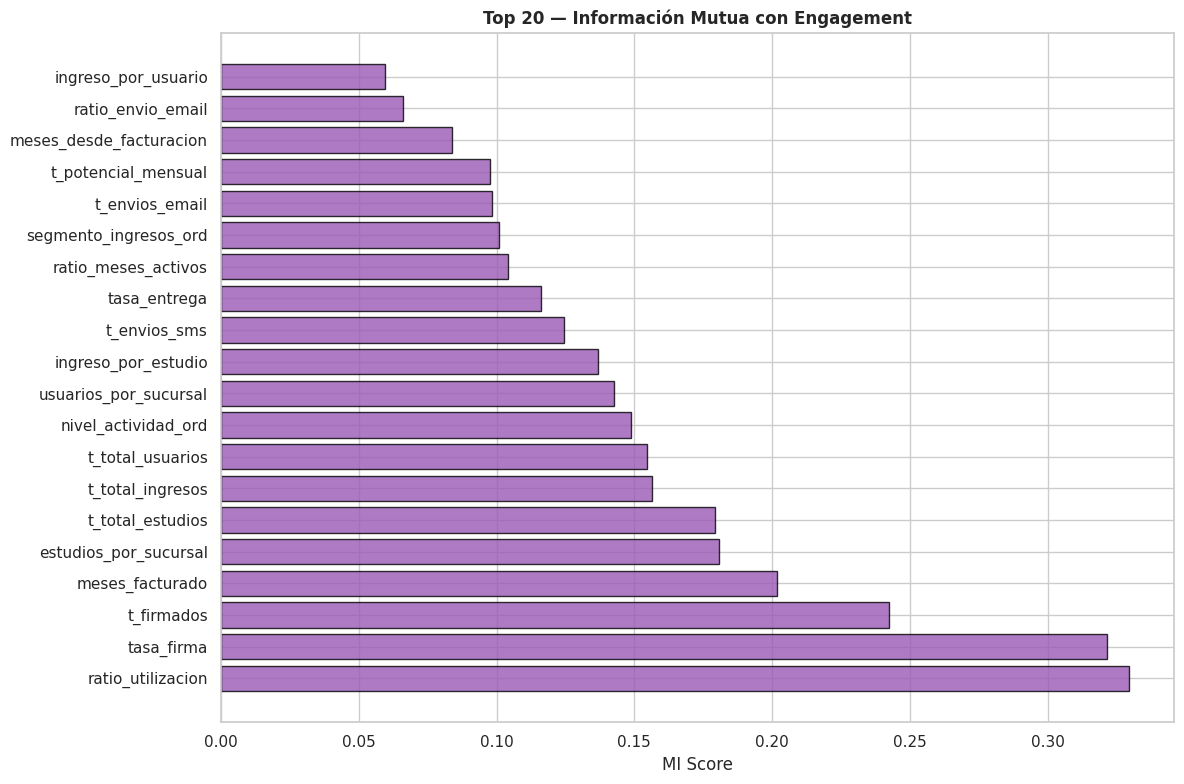

In [55]:
# 9.5 Información Mutua
all_selection_features = list(dict.fromkeys(kept_corr + chi2_features))
all_selection_features = [f for f in all_selection_features if f in df_encoded.columns]

X_mi = df_encoded[all_selection_features].fillna(0)
y_mi = df_encoded['engagement_ord']

mi_scores = mutual_info_classif(X_mi, y_mi, random_state=42, n_neighbors=5)

mi_df = pd.DataFrame({
    'Feature': all_selection_features,
    'MI_score': mi_scores
}).sort_values('MI_score', ascending=False)

print('Información Mutua — Top 20 features:')
display(mi_df.head(20).style.format({'MI_score': '{:.4f}'})
        .background_gradient(subset=['MI_score'], cmap='Purples'))

# Visualización
fig, ax = plt.subplots(figsize=(12, 8))
top_mi = mi_df.head(20)
ax.barh(top_mi['Feature'], top_mi['MI_score'], color='#9b59b6', edgecolor='black', alpha=0.8)
ax.set_title('Top 20 — Información Mutua con Engagement', fontweight='bold')
ax.set_xlabel('MI Score')
plt.tight_layout()
plt.show()

### 9.6 Consenso de métodos de selección

**Justificación:** Cada método de filtrado tiene sesgos: ANOVA favorece relaciones lineales, Chi² favorece categorías, MI captura no-linealidades. Un enfoque de **consenso** (features seleccionadas por al menos 2 métodos) produce un subconjunto más robusto.

In [56]:
# 9.6 Consenso de selección
# Top features por cada método (top-k donde k = ~60% del total)
k_anova = max(5, int(len(anova_sig) * 0.8))
k_chi2 = max(5, int(len(chi2_scores[chi2_scores['p_value'] < 0.05]) * 0.8))
k_mi = max(5, int(len(mi_df) * 0.5))

top_anova = set(anova_scores.head(k_anova)['Feature'])
top_chi2 = set(chi2_scores.head(k_chi2)['Feature'])
top_mi = set(mi_df.head(k_mi)['Feature'])

# Consenso: seleccionado por al menos 1 método
all_selected = top_anova | top_chi2 | top_mi
# Consenso fuerte: seleccionado por al menos 2 métodos
strong_consensus = (top_anova & top_mi) | (top_anova & top_chi2) | (top_chi2 & top_mi)

# Crear tabla de votación
vote_data = []
all_candidates = sorted(set(list(top_anova) + list(top_chi2) + list(top_mi)))
for f in all_candidates:
    votes = sum([f in top_anova, f in top_chi2, f in top_mi])
    vote_data.append({
        'Feature': f,
        'ANOVA': '✅' if f in top_anova else '—',
        'Chi²': '✅' if f in top_chi2 else '—',
        'MI': '✅' if f in top_mi else '—',
        'Votos': votes
    })

df_votes = pd.DataFrame(vote_data).sort_values('Votos', ascending=False)

print(f'Consenso de selección de features:')
print(f'  ANOVA top {k_anova}:  {len(top_anova)} features')
print(f'  Chi² top {k_chi2}:   {len(top_chi2)} features')
print(f'  MI top {k_mi}:       {len(top_mi)} features')
print(f'  Unión:               {len(all_selected)} features')
print(f'  Consenso (≥2 votos): {len(strong_consensus)} features')

display(df_votes.head(25))

Consenso de selección de features:
  ANOVA top 14:  14 features
  Chi² top 8:   8 features
  MI top 23:       23 features
  Unión:               26 features
  Consenso (≥2 votos): 19 features


,Feature,ANOVA,Chi²,MI,Votos
1,es_multi_modalidad,—,✅,✅,2
3,estudios_por_sucursal,✅,—,✅,2
8,nivel_actividad_ord,—,✅,✅,2
4,ingreso_por_estudio,✅,—,✅,2
7,meses_facturado,✅,—,✅,2
6,meses_desde_facturacion,✅,—,✅,2
14,t_envios_email,✅,—,✅,2
15,t_envios_sms,✅,—,✅,2
13,segmento_ingresos_ord,—,✅,✅,2
11,ratio_meses_activos,✅,—,✅,2


In [57]:
# Resumen del pipeline de selección
print('═' * 65)
print('PIPELINE DE SELECCIÓN DE FEATURES')
print('═' * 65)
print(f'  1. Features iniciales (post-generación): {len(features_num) + len(chi2_features)}')
print(f'  2. Post-umbral varianza:                 {len(kept_var)}')
print(f'  3. Post-filtro correlación:               {len(kept_corr)}')
print(f'  4. ANOVA significativas (p<0.05):         {len(anova_sig)}')
print(f'  5. Chi² significativas (p<0.05):          {len(chi2_scores[chi2_scores["p_value"]<0.05])}')
print(f'  6. Consenso final (≥1 método):            {len(all_selected)}')
print(f'  {"─"*55}')
print(f'  → Features para Fase 3 (modelado):       {len(all_selected)}')

═════════════════════════════════════════════════════════════════
PIPELINE DE SELECCIÓN DE FEATURES
═════════════════════════════════════════════════════════════════
  1. Features iniciales (post-generación): 62
  2. Post-umbral varianza:                 24
  3. Post-filtro correlación:               18
  4. ANOVA significativas (p<0.05):         18
  5. Chi² significativas (p<0.05):          11
  6. Consenso final (≥1 método):            26
  ───────────────────────────────────────────────────────
  → Features para Fase 3 (modelado):       26


<a name="extraccion"></a>
## 10. Extracción de Características — PCA y Análisis Factorial

> **Motivación (EDA):** La alta correlación entre variables de uso (r > 0.90) sugiere que la información puede comprimirse en menos dimensiones sin pérdida significativa.
>
> **Objetivo para Fase 3:** Proporcionar versiones reducidas del dataset que pueden mejorar rendimiento de modelos sensibles a dimensionalidad (Regresión Logística, SVM).

### 10.1 Análisis de Componentes Principales (PCA)

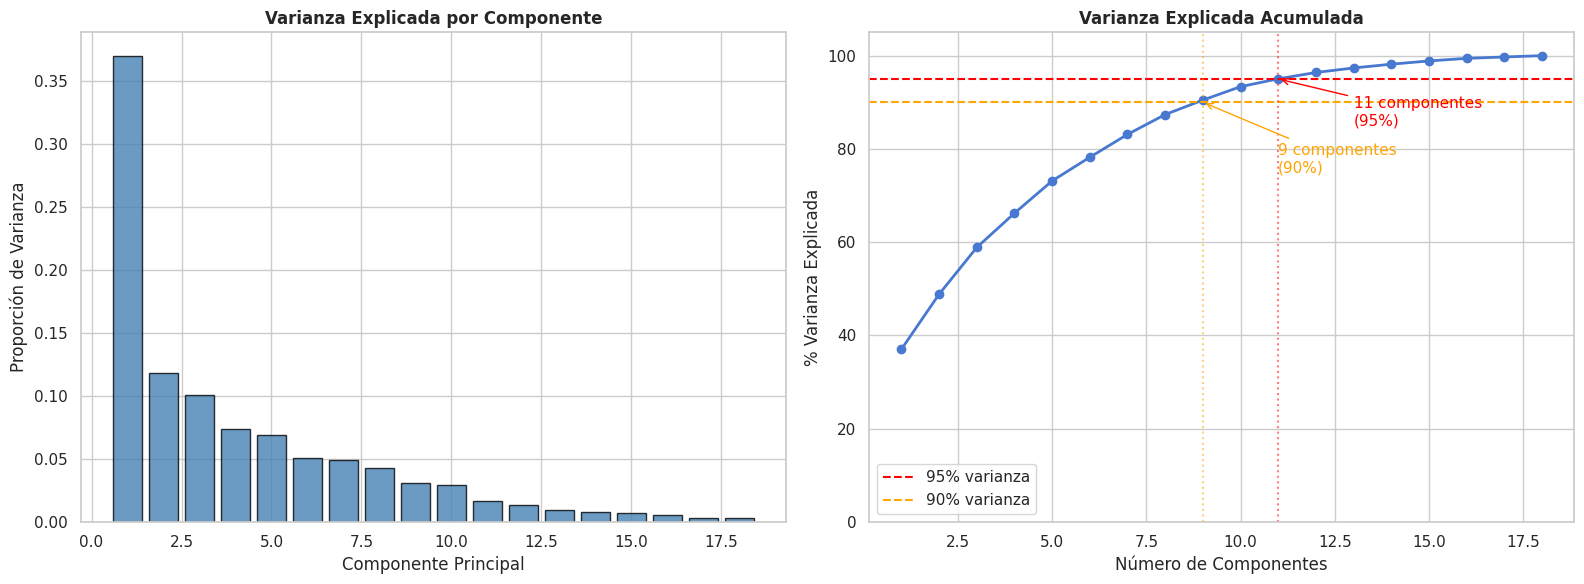

Componentes para 90% varianza: 9 (de 18 originales)
Componentes para 95% varianza: 11 (de 18 originales)
Ratio de compresión (95%):     1.6x


In [58]:
# 10.1 PCA
# Usar features numéricos escalados (StandardScaler para PCA)
pca_features = [f for f in kept_corr if f in scaled_dfs['StandardScaler'].columns]
X_pca = scaled_dfs['StandardScaler'][pca_features].fillna(0)

# PCA completo para análisis de varianza explicada
pca_full = PCA(random_state=42)
pca_full.fit(X_pca)

# Varianza explicada acumulada
var_explained = np.cumsum(pca_full.explained_variance_ratio_)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scree plot
ax = axes[0]
ax.bar(range(1, len(pca_full.explained_variance_ratio_) + 1),
       pca_full.explained_variance_ratio_, color='steelblue', edgecolor='black', alpha=0.8)
ax.set_title('Varianza Explicada por Componente', fontweight='bold')
ax.set_xlabel('Componente Principal')
ax.set_ylabel('Proporción de Varianza')

# Acumulada
ax = axes[1]
ax.plot(range(1, len(var_explained) + 1), var_explained * 100, 'bo-', lw=2, ms=6)
ax.axhline(95, color='red', ls='--', label='95% varianza')
ax.axhline(90, color='orange', ls='--', label='90% varianza')
n_95 = np.argmax(var_explained >= 0.95) + 1
n_90 = np.argmax(var_explained >= 0.90) + 1
ax.axvline(n_95, color='red', ls=':', alpha=0.5)
ax.axvline(n_90, color='orange', ls=':', alpha=0.5)
ax.annotate(f'{n_95} componentes\n(95%)', xy=(n_95, 95), xytext=(n_95+2, 85),
            arrowprops=dict(arrowstyle='->', color='red'), fontsize=11, color='red')
ax.annotate(f'{n_90} componentes\n(90%)', xy=(n_90, 90), xytext=(n_90+2, 75),
            arrowprops=dict(arrowstyle='->', color='orange'), fontsize=11, color='orange')
ax.set_title('Varianza Explicada Acumulada', fontweight='bold')
ax.set_xlabel('Número de Componentes')
ax.set_ylabel('% Varianza Explicada')
ax.legend()
ax.set_ylim(0, 105)

plt.tight_layout()
plt.show()

print(f'Componentes para 90% varianza: {n_90} (de {len(pca_features)} originales)')
print(f'Componentes para 95% varianza: {n_95} (de {len(pca_features)} originales)')
print(f'Ratio de compresión (95%):     {len(pca_features)/n_95:.1f}x')

In [59]:
# ── PCA con componentes óptimos (95%) ────────────────
pca_opt = PCA(n_components=n_95, random_state=42)
X_pca_transformed = pca_opt.fit_transform(X_pca)

# Loadings (contribución de cada feature a cada componente)
loadings = pd.DataFrame(
    pca_opt.components_.T,
    columns=[f'PC{i+1}' for i in range(n_95)],
    index=pca_features
)

print(f'PCA aplicado: {len(pca_features)} features → {n_95} componentes (95% varianza)')
print(f'\nTop contribuciones por componente:')

for i in range(min(3, n_95)):
    pc = f'PC{i+1}'
    top_pos = loadings[pc].nlargest(3)
    top_neg = loadings[pc].nsmallest(3)
    var_pct = pca_opt.explained_variance_ratio_[i] * 100
    print(f'\n  {pc} ({var_pct:.1f}% varianza):')
    print(f'    Positivo: {", ".join([f"{n} ({v:.3f})" for n, v in top_pos.items()])}')
    print(f'    Negativo: {", ".join([f"{n} ({v:.3f})" for n, v in top_neg.items()])}')

# Guardar componentes PCA
df_pca = pd.DataFrame(X_pca_transformed, columns=[f'PC{i+1}' for i in range(n_95)],
                       index=df_encoded.index)

PCA aplicado: 18 features → 11 componentes (95% varianza)

Top contribuciones por componente:

  PC1 (37.0% varianza):
    Positivo: t_total_estudios (0.359), t_envios_sms (0.349), t_total_usuarios (0.331)
    Negativo: ingreso_por_estudio (-0.107), ingreso_por_usuario (0.031), t_potencial_mensual (0.034)

  PC2 (11.8% varianza):
    Positivo: tasa_entrega (0.532), ratio_envio_email (0.507), t_envios_email (0.253)
    Negativo: tasa_firma (-0.474), t_firmados (-0.276), ratio_utilizacion (-0.158)

  PC3 (10.0% varianza):
    Positivo: ingreso_por_usuario (0.492), ratio_utilizacion (0.427), estudios_por_sucursal (0.259)
    Negativo: tasa_firma (-0.360), t_potencial_mensual (-0.341), t_total_usuarios (-0.227)


### 10.2 Análisis Factorial (FA)

**Justificación:** Mientras PCA maximiza varianza explicada, el Análisis Factorial busca **factores latentes** que expliquen la estructura de correlación. Es más interpretable para entender qué constructos subyacentes existen en los datos (e.g., "tamaño de organización", "intensidad de uso", "engagement digital").

Análisis Factorial: 18 features → 5 factores

Interpretación de factores latentes:

  Factor_1:
    Variables dominantes: t_firmados (+0.937), t_total_usuarios (+0.883), t_total_estudios (+0.880), t_total_ingresos (+0.796), t_envios_sms (+0.794)

  Factor_2:
    Variables dominantes: tasa_firma (-0.689), meses_desde_facturacion (+0.530), meses_facturado (+0.417), t_envios_email (+0.410), t_envios_sms (+0.405)

  Factor_3:
    Variables dominantes: ratio_meses_activos (-0.741), meses_desde_facturacion (+0.660), tasa_entrega (-0.227), tasa_firma (+0.199), t_total_ingresos (-0.192)

  Factor_4:
    Variables dominantes: tasa_entrega (-0.495), ingreso_por_usuario (+0.452), ratio_utilizacion (+0.348), ratio_envio_email (-0.341), t_total_usuarios (-0.329)

  Factor_5:
    Variables dominantes: tasa_entrega (-0.536), ratio_envio_email (-0.405), meses_facturado (+0.390), ratio_meses_activos (+0.342), t_envios_email (-0.272)


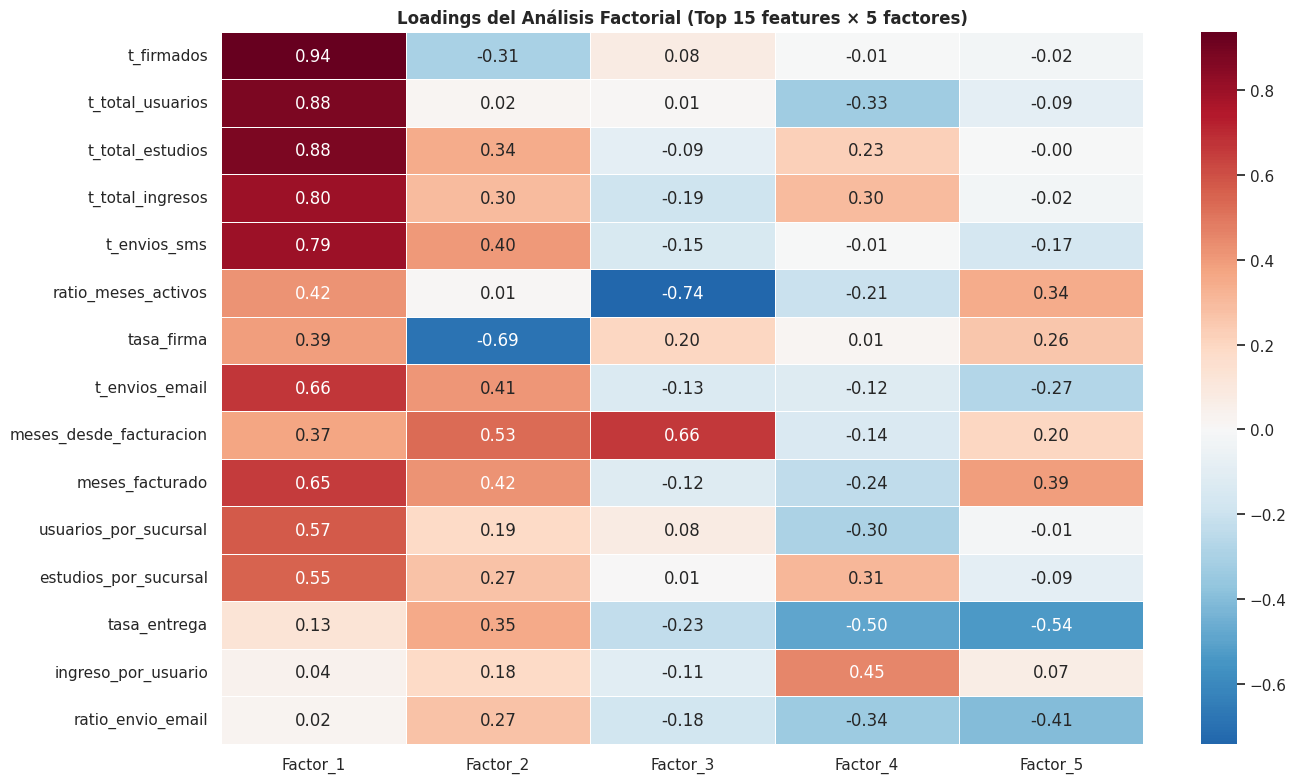

In [60]:
# ── 10.2 Análisis Factorial ───────────────────────────
n_factors = min(n_90, 5)  # Usar número conservador de factores

fa = FactorAnalysis(n_components=n_factors, random_state=42)
X_fa_transformed = fa.fit_transform(X_pca)

# Loadings factoriales
fa_loadings = pd.DataFrame(
    fa.components_.T,
    columns=[f'Factor_{i+1}' for i in range(n_factors)],
    index=pca_features
)

# Interpretar factores
print(f'Análisis Factorial: {len(pca_features)} features → {n_factors} factores')
print(f'\nInterpretación de factores latentes:')

for i in range(n_factors):
    factor = f'Factor_{i+1}'
    top = fa_loadings[factor].abs().nlargest(5)
    top_names = [f'{n} ({"+" if fa_loadings.loc[n, factor] > 0 else "-"}{abs(fa_loadings.loc[n, factor]):.3f})'
                 for n in top.index]
    print(f'\n  {factor}:')
    print(f'    Variables dominantes: {", ".join(top_names)}')

# Visualización de loadings
fig, ax = plt.subplots(figsize=(14, 8))
top_fa_vars = fa_loadings.abs().max(axis=1).nlargest(15).index
sns.heatmap(fa_loadings.loc[top_fa_vars], annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, ax=ax, linewidths=0.5)
ax.set_title(f'Loadings del Análisis Factorial (Top 15 features × {n_factors} factores)',
             fontweight='bold')
plt.tight_layout()
plt.show()

# Guardar factores
df_fa = pd.DataFrame(X_fa_transformed, columns=[f'Factor_{i+1}' for i in range(n_factors)],
                      index=df_encoded.index)

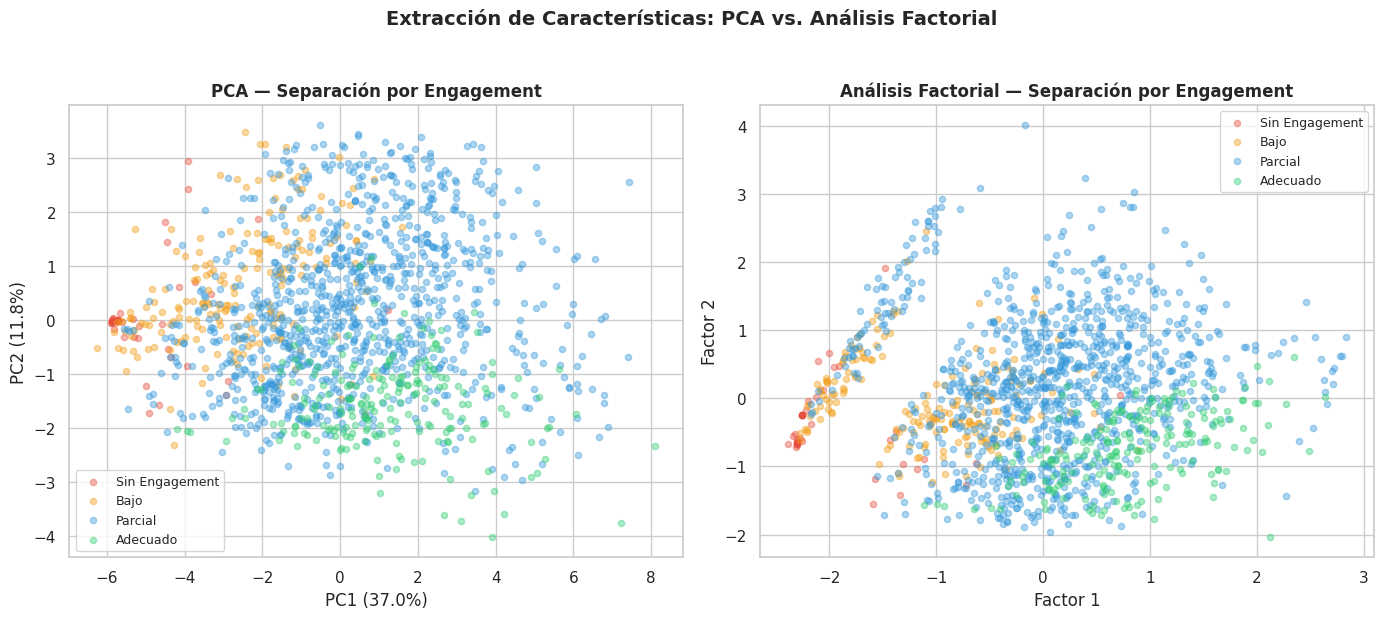

Observación: La separación visual entre clases de engagement en el espacio
reducido valida que las features contienen información discriminativa para la Fase 3.


In [61]:
# ── Comparación PCA vs FA ────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# PCA: PC1 vs PC2 coloreado por engagement
ax = axes[0]
colors_map = {'Sin Engagement': '#e74c3c', 'Bajo': '#f39c12', 'Parcial': '#3498db', 'Adecuado': '#2ecc71'}
for eng in ['Sin Engagement', 'Bajo', 'Parcial', 'Adecuado']:
    mask = df_encoded['engagement'] == eng
    ax.scatter(df_pca.loc[mask, 'PC1'], df_pca.loc[mask, 'PC2'],
               alpha=0.4, s=20, c=colors_map[eng], label=eng)
ax.set_xlabel(f'PC1 ({pca_opt.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca_opt.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_title('PCA — Separación por Engagement', fontweight='bold')
ax.legend(fontsize=9)

# FA: Factor 1 vs Factor 2
ax = axes[1]
for eng in ['Sin Engagement', 'Bajo', 'Parcial', 'Adecuado']:
    mask = df_encoded['engagement'] == eng
    ax.scatter(df_fa.loc[mask, 'Factor_1'], df_fa.loc[mask, 'Factor_2'],
               alpha=0.4, s=20, c=colors_map[eng], label=eng)
ax.set_xlabel('Factor 1')
ax.set_ylabel('Factor 2')
ax.set_title('Análisis Factorial — Separación por Engagement', fontweight='bold')
ax.legend(fontsize=9)

plt.suptitle('Extracción de Características: PCA vs. Análisis Factorial',
             fontsize=14, fontweight='bold', y=1.03)
plt.tight_layout()
plt.show()

print('Observación: La separación visual entre clases de engagement en el espacio')
print('reducido valida que las features contienen información discriminativa para la Fase 3.')

<a name="final"></a>
## 11. Dataset Final para Modelado

Se ensambla el dataset definitivo que será input de la **Fase 3 (Baseline)**. Se proporcionan tres versiones para evaluar qué representación funciona mejor con cada algoritmo:

| Versión | Contenido | Algoritmos recomendados |
|---------|-----------|------------------------|
| **A. Features completas** | Features seleccionadas (consenso) + flags + OHE | Random Forest, XGBoost |
| **B. Features escaladas** | Versión A con StandardScaler | Regresión Logística, SVM |
| **C. PCA reducido** | Componentes principales (95% varianza) + flags | Análisis exploratorio, validación rápida |

In [62]:
# ENSAMBLE DEL DATASET FINAL PARA FASE 3

# Features seleccionadas por consenso (numéricos)
selected_num = [f for f in all_selected if f in df_encoded.columns]

# Features categóricos (OHE + flags)
selected_cat = [c for c in df_encoded.columns
                if c.startswith('prod_') or c.startswith('pais_')]
selected_cat += flags
selected_cat = list(dict.fromkeys([c for c in selected_cat if c in df_encoded.columns]))

# Combinar todos los features
all_features = list(dict.fromkeys(selected_num + selected_cat))
all_features = [f for f in all_features if f in df_encoded.columns]

# Versión A: Features completas
X_full = df_encoded[all_features].fillna(0)
y = df_encoded['engagement_ord']

# Versión B: Features escaladas
scaler_final = StandardScaler()
num_in_full = [c for c in selected_num if c in X_full.columns]
cat_in_full = [c for c in selected_cat if c in X_full.columns]

X_scaled = X_full.copy()
X_scaled[num_in_full] = scaler_final.fit_transform(X_full[num_in_full])

# Versión C: PCA reducido + flags
X_pca_final = pd.concat([df_pca, df_encoded[flags].fillna(0)], axis=1)

# Train/Test Split (80/20, estratificado)
X_train_A, X_test_A, y_train, y_test = train_test_split(
    X_full, y, test_size=0.2, random_state=42, stratify=y)

X_train_B, X_test_B, _, _ = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

X_train_C, X_test_C, _, _ = train_test_split(
    X_pca_final, y, test_size=0.2, random_state=42, stratify=y)

print('═' * 65)
print('DATASETS PARA FASE 3 — BASELINE')
print('═' * 65)
print(f'\n  Variable objetivo (y):   {y.nunique()} clases')
for cls in sorted(y.unique()):
    eng_label = {0: 'Sin Engagement', 1: 'Bajo', 2: 'Parcial', 3: 'Adecuado'}[cls]
    n_train = (y_train == cls).sum()
    n_test = (y_test == cls).sum()
    print(f'    {cls} ({eng_label:<18}): train={n_train:>4}  test={n_test:>4}')

print(f'\n  Versión A (completa):     {X_train_A.shape[1]} features  train={X_train_A.shape[0]}  test={X_test_A.shape[0]}')
print(f'  Versión B (escalada):     {X_train_B.shape[1]} features  train={X_train_B.shape[0]}  test={X_test_B.shape[0]}')
print(f'  Versión C (PCA+flags):    {X_train_C.shape[1]} features  train={X_train_C.shape[0]}  test={X_test_C.shape[0]}')

═════════════════════════════════════════════════════════════════
DATASETS PARA FASE 3 — BASELINE
═════════════════════════════════════════════════════════════════

  Variable objetivo (y):   4 clases
    0 (Sin Engagement    ): train=  32  test=   8
    1 (Bajo              ): train= 160  test=  40
    2 (Parcial           ): train= 819  test= 205
    3 (Adecuado          ): train= 169  test=  43

  Versión A (completa):     45 features  train=1180  test=296
  Versión B (escalada):     45 features  train=1180  test=296
  Versión C (PCA+flags):    18 features  train=1180  test=296


In [63]:
# Exportar datasets para Fase 3
import pickle

output = {
    'X_train_A': X_train_A, 'X_test_A': X_test_A,
    'X_train_B': X_train_B, 'X_test_B': X_test_B,
    'X_train_C': X_train_C, 'X_test_C': X_test_C,
    'y_train': y_train, 'y_test': y_test,
    'feature_names': all_features,
    'engagement_map': engagement_map,
    'scaler': scaler_final,
    'pca': pca_opt,
}

# Guardar (descomentar la ruta apropiada)
pickle.dump(output, open('/content/drive/MyDrive/proyecto integrador (grupo 4)/fase2_output.pkl', 'wb'))
pickle.dump(output, open('fase2_output.pkl', 'wb'))

# También exportar el df completo procesado
df_encoded.to_csv('df_fase2_completo.csv', index=False)

print('✅ Archivos exportados:')
print('   • fase2_output.pkl  — Datasets train/test + transformadores')
print('   • df_fase2_completo.csv — DataFrame completo procesado')
print('\n   Estos archivos son el INPUT directo de la Fase 3 (Baseline)')

✅ Archivos exportados:
   • fase2_output.pkl  — Datasets train/test + transformadores
   • df_fase2_completo.csv — DataFrame completo procesado

   Estos archivos son el INPUT directo de la Fase 3 (Baseline)


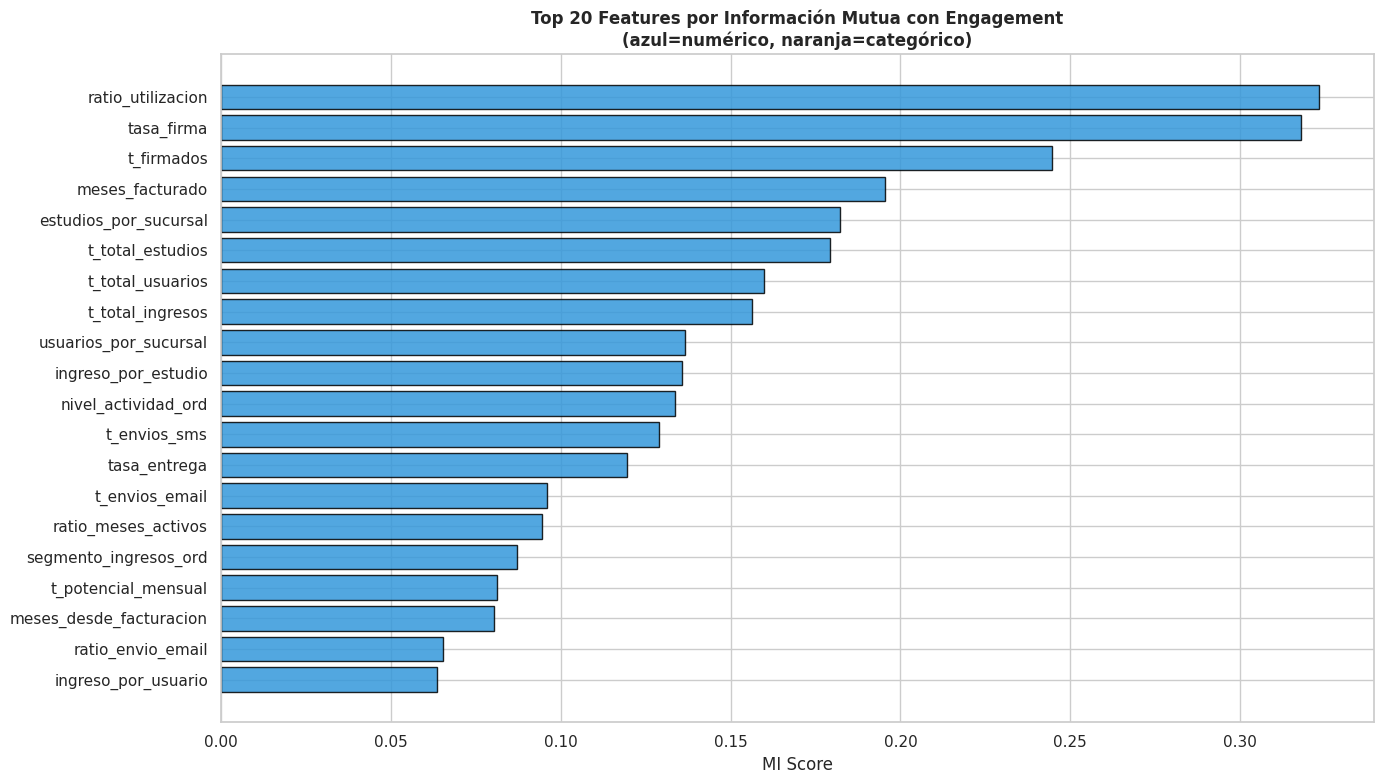

In [64]:
# Visualización final: importancia relativa de features
fig, ax = plt.subplots(figsize=(14, 8))

# Usar información mutua como proxy de importancia
mi_final = mutual_info_classif(X_full.fillna(0), y, random_state=42, n_neighbors=5)
imp_df = pd.DataFrame({
    'Feature': all_features[:len(mi_final)],
    'MI_score': mi_final
}).sort_values('MI_score', ascending=True).tail(20)

colors = ['#3498db' if not f.startswith('prod_') and not f.startswith('pais_')
          and f not in flags else '#e67e22' for f in imp_df['Feature']]
ax.barh(imp_df['Feature'], imp_df['MI_score'], color=colors, edgecolor='black', alpha=0.85)
ax.set_title('Top 20 Features por Información Mutua con Engagement\n(azul=numérico, naranja=categórico)',
             fontweight='bold')
ax.set_xlabel('MI Score')
plt.tight_layout()
plt.show()

<a name="conclusiones"></a>
## 12. Conclusiones — Preparación de Datos (CRISP-ML)

---

### 12.1 Resumen de operaciones aplicadas

| Etapa | Técnica | Variables afectadas | Justificación |
|-------|---------|---------------------|---------------|
| **Generación** | Ratios de negocio (10 vars) | Todas las métricas absolutas | Normalizar por tamaño; capturar eficiencia vs. escala (EDA) |
| **Generación** | Features temporales (4 vars) | Fechas de instalación/facturación | Capturar madurez y velocidad de onboarding (Propuesta §2) |
| **Generación** | Flags de adopción (7 vars) | AI, envíos, multi-sucursal | Codificar adopción de funcionalidades avanzadas (EDA §9.1) |
| **Discretización** | Binning por cuantiles | Ingresos, actividad | Balancear distribución de bins (EDA §13) |
| **Discretización** | Binning por negocio | Antigüedad, onboarding, tamaño | Umbrales con significado operativo (Propuesta §2) |
| **Codificación** | One-Hot Encoding | `product_type`, `pais` | Variables nominales sin orden natural (EDA §7) |
| **Codificación** | Ordinal Encoding | Variables binned, engagement | Variables con orden natural inherente |
| **Transformación** | Yeo-Johnson / Box-Cox / Log(x+1) | 13 variables numéricas | Mejor transformación por variable para reducir sesgo (EDA §8) |
| **Escalamiento** | Standard, MinMax, Robust | Todos los features numéricos | 3 versiones para evaluar en Fase 3 según algoritmo |
| **Selección** | Umbral varianza (< 0.01) | Features numéricos | Eliminar features sin información discriminativa |
| **Selección** | Correlación (|r| > 0.90) | Features redundantes | Resolver multicolinealidad detectada en EDA §11 |
| **Selección** | ANOVA F-test | Features numéricos vs. engagement | Evaluar significancia estadística lineal |
| **Selección** | Chi-cuadrado | Features categóricos vs. engagement | Evaluar independencia con variable objetivo |
| **Selección** | Información Mutua | Todos los features | Capturar relaciones no lineales |
| **Extracción** | PCA | Features numéricos | Compresión dimensional manteniendo 95% varianza |
| **Extracción** | Análisis Factorial | Features numéricos | Identificar factores latentes interpretables |

### 12.2 Trazabilidad EDA → FE → Modelado

| Hallazgo EDA | Acción en FE | Entregable para Fase 3 |
|-------------|-------------|----------------------|
| Sesgo extremo en distribuciones | Transformación óptima por variable (Yeo-Johnson > Log en varias) | Features con distribuciones normalizadas |
| Multicolinealidad (r > 0.90) | Filtro correlación + PCA | Features ortogonales, sin redundancia |
| Potencial ≠ Ingresos | `ratio_utilizacion` como feature y base del target | Variable objetivo de engagement definida |
| Concentración Pareto | Discretización en segmentos de engagement | Clasificación multiclase balanceable |
| Baja adopción AI | Flags binarios `usa_ai_*` | Predictores de funcionalidad avanzada |
| Alta cardinalidad en `name` | Excluido del modelo; solo ID | Sin data leakage |

### 12.3 Entregables para la Fase 3 — Modelo Baseline

La Fase 3 recibirá:

1. **Tres versiones del dataset** (A: completa, B: escalada, C: PCA reducida) con split train/test estratificado
2. **Variable objetivo multiclase** (`engagement_ord`: 0–3) definida por reglas de negocio
3. **Transformadores serializados** (scaler, PCA) para aplicar las mismas transformaciones a datos nuevos
4. **Documentación de features** con justificación de cada variable incluida/excluida

> **Meta de la Fase 3:** Establecer un modelo baseline (Regresión Logística o Decision Tree) que proporcione métricas de referencia (accuracy, precision, recall, F1-score) contra las cuales se evaluarán modelos más avanzados (Random Forest, XGBoost).

### 12.4 Anticipación de la Fase 3 — Baseline

La siguiente fase tiene como objetivo **establecer las medidas de calidad del modelo de aprendizaje automático y proporcionar un marco de referencia** para evaluar y mejorar modelos más avanzados.

**Plan de la Fase 3:**

```
Fase 3: Modelo Baseline
├── 1. Carga de datasets (fase2_output.pkl)
├── 2. Baseline simple (Regresión Logística / Dummy Classifier)
│   ├── Métricas: accuracy, precision, recall, F1 (macro/weighted)
│   ├── Matriz de confusión
│   └── Curva ROC multiclase
├── 3. Primer modelo complejo (Random Forest)
│   ├── Comparación con baseline
│   ├── Importancia de features
│   └── Validación cruzada (5-fold)
├── 4. Evaluación por versión de datos (A vs B vs C)
├── 5. Análisis de errores
│   ├── ¿Qué clases confunde más?
│   ├── ¿Qué organizaciones clasifica mal?
│   └── → Feedback para mejorar features
└── 6. Conclusiones y roadmap
    ├── Métricas de referencia establecidas
    ├── Gap identificado vs. modelos avanzados
    └── Recomendaciones para optimización
```
